In [11]:
%pylab inline
import scipy
from scipy import signal
plt.style.use('classic')

Populating the interactive namespace from numpy and matplotlib


In [22]:
def settling(w,mode = 'linear', fs = 10000, period=20, time = 0.05):
    '''
    Calculate the amount of time in each step that is needed for the filter 
      and frequency signal to settle.
    In a 'dynamic' situation, where the time per step is proportional to the 
      frequency and tested number of periods, this time is dependent on the 
      frequency being tested. ***Prefered method
    In a 'linear' situation, where the time per step is equal at every frequency
      that is tested, this time also ends up being equal for every frequency
    Returns the number of bins for that time
    
    Inputs:
        w      - Required: float denoting reference frequency
        mode   - Optional: String for version determinization of
                            time calculation  Options: 'dynamic', 'linear'
        fs     - Optional: int denoting sampling rate of data collection
        period - Optional: int determining number of periods for dynamic mode
        time   - Optional: float determining the settling time for linear mode
    
    Returns:
        set_time - int containing number of bins to wait before performing lockin calc
    '''
    set_time = 0 #set a default time if neither mode is chosen
    
    if mode == 'linear':
        set_time = time*fs #Set a standard time regardless of frequency
    if mode == 'dynamic':  #Set the time proportional to the frequency tested
        set_time = (period/w)*fs
    return int(set_time)

def lockin(data,freq,fs=10000):
    '''
    Calculate the magnitude and phase of a signal in the data with 
    respect to the reference frequency
    
    Inputs:
        data - Required: array containing discrete sampled time series data
        freq - Required: float for reference frequency that needs to be isolated from data
        fs   - Optional: int stating sampling rate of data collection
        
    Returns:
        LI_data - Complex number denoting magnitude and phase of isolated signal
    '''
    t = linspace(0,len(data)/fs,len(data))  # time array for generating the ref signal
    set_time = settling(freq)      #amount of time needed for the filter and 
                                   #  lockin amplifier to settle proportional to freq
    ref_sig = exp(-1j*freq*2*pi*t) #create the reference signal
    data_mix = data*ref_sig        #Mix the ref signal with the chopped data
    #5 cascaded second-order lowpass sections are used to isolate the DC component
    #     produced from the signal mixing with a cutoff frequency << w. This gives 
    #     the equivalent of the fft bin value if a Fourier transform was 
    #     able to be properly calculated.
    sos = signal.butter(6, freq, 'lowpass', fs=fs, output='sos')
    
    #A forward-backward digital filter using the cascaded sections
    #   results in filter with zero phase change
    data_filt = signal.sosfiltfilt(sos,data_mix)
    
    #In a discretly sampled series, the average of data points is equal to
    #   the integral over the same period
    #A time proportional to w at the beginning of the data is ignored for 
    #   settling time of the filter and signal driven by the lockin amplifier
    LI_data = average(data_filt[set_time:])
    return LI_data

def coef(C,w,inpt,outpt,p1,p2,n,i,fs=10000):
    '''
    Calculate the response the output signal has to the input signal,
    isolated using a reference frequency with respect to 'w', also
    removing the impact that frequencies other than the harmonic response 
    have on the output signal 
        
    Inputs:
        C     - Required: 2D numpy array as the coefficient matrix
        w     - Required: float denoting the fundamental frequency
        intpt - Required: 1D numpy array used to calculate the
                          denominator of the transfer function (Geophone signal)
        outpt - Required: 1D numpy array used to calculate the 
                          numerator of the transfer function (Z position, Current, or LIY)
        p1    - Required: int representing the beginning of the calibration step
        p2    - Required: int representing the end of the calibration step
        n     - Required: int stating the harmonic of w that is being calculated 
        i     - Required: int bin location of w in the coefficient matrix
        fs    - Optional: int stating sampling rate of data collection
    
    Returns:
        coefficient - complex representation of how a signal is transfered from 
                        the input to the output
    '''
    
    #If the harmonic freq. is above the Nyquist freq. do not try to calculate it
    if n*w >= fs/2:
        return 0 + 0*1j
    
    k = linspace(0,n-1,n).astype('int')  #Identify the integer harmonics below the 
                                         #  calculated harmonic being found
    inpt = inpt[p1:p2]-mean(inpt[p1:p2]) #Remove the dc component from the calibration step
    outpt = outpt[p1:p2]                 #isolate the determined calibration step
    LI_out = lockin(outpt,n*w)           #Calculate the magnitude and phase of the signal
                                         #  with respect to the harmonic reference
                                         #  signal in output data
    LI_in = lockin(inpt,w)               #Same with the fundamental input data
    LI_sub = 0 + 0j                      #Initiate the interefering input signal 
    #Iterate through each harmonic that is below the one being calculated
    #   Using them to make sure that the lockin signal is the result of harmonic distortion
    for sub in k:
        if sub == 0:  #If the first harmonic is being calculated there is not other 
                      #  interference in the input signal
            continue
        if (n*w/sub) > end:
            return 0+0j
        LI_in_k = lockin(inpt,(n*w)/sub) #Calculate the mag and phase of signal 
                                         #  with respect to the harmonics
        #Calculate the sum of interfering signals
        #  Estimated using the already defined coefficients
        LI_sub = LI_sub + C[int(n*i/sub),n-1]*LI_in_k
        
    coefficient = (LI_out-LI_sub)/LI_in #Return the calculated coefficient
    return coefficient

def nearest(array, value):
    '''
    Finds the nearest value in 'array' to 'value' and 
      and returns the indexed value of the array
      
    Inputs:
        array  - Required: 1D numpy array or list
        value  - Required: float/int value to find nearest index of 
        
    Returns:
        idx    - int, index of array bin value closest to 'value'
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def calibrate(inpt,outpt,start=50,end=400,harmonics=5,steps=35000,fs=10000):
    '''
    Calibrates each coefficient using the already cut calibration data
    (cut to the beginning and end of the calibration chirp)
    
    Inputs:
        intpt    - Required: 1D numpy array used to calculate the
                          denominator of the transfer function (Geophone signal)
        outpt    - Required: 1D numpy array used to calculate the 
                          numerator of the transfer function (Z position, Current, or LIY)
        start    - Optional: int/float denoting the starting frequency of the chirp
        end      - Optional: int/float denoting the ending frequency of the chirp
        harmonics- Optional: number of hamronics/coefficients to be calculated
        steps    - Optional: number of frequency steps in the calibration chirp
        fs       - Optional: int stating sampling rate of data collection
        
    Returns:
        coef_mat - 1D/2D list of complex interpolations representing the response of 
                          the output data to the input data during calibration
    '''

    #This identifies the location of each change of frequency
    #  *Since the step length was too small for proper calibration 30 steps 
    #  are being averaged together, leading to some amount of error
    stitch = 30 #Stitching 30 frequency steps together
    loc = linspace(0,len(t),int(steps/stitch)).astype('int')
    st_off = ((end-start)*stitch)/steps #new resolution of coefficients
    lock_loc = st_off*0.5 #Variable value 0-1, dictates which part of the 
                          #  stiched frequencies to lock into 
                          #  0 = beginning, 0.5 = middle, 1 = end
    #Identify the reference frequency for each step to lock on to
    freq_map = linspace(start+lock_loc,end-st_off+lock_loc,len(loc)) 

    #Calculate the fft size that produces the same frequeny resolution
    fftfreq = fft.fftfreq(int(fs/(freq_map[1]-freq_map[0])),1/fs)

    #Initialize the coefficient matrix
    C = np.zeros((len(fftfreq),harmonics),dtype='complex128')
    #find the bin location nearest to the start of the coefficient bandwidth
    idx = nearest(fftfreq,freq_map[0]) 
    #Calibrate the frequency response at each harmonic
    for n in arange(harmonics):
        prev = 0
        #Iterate through each frequency within the calibration bandwidth
        for w,point,i in zip(freq_map,loc[1:],arange(len(fftfreq))):
            #Harmonic response can only be found within the frequency bandwidth
            if (n+1)*w > end:
                continue
            i = i + idx #The calibration bandwdith does not start at 0 Hz
            #Call the function to calculate the coefficient
            C[i,n] = coef(C,w,inpt,outpt,prev,point,n+1,i,fs=fs)
            prev = point #Assign the beginning of the next frequency step
            print(n+1,'   ',fftfreq[i],end='\r') #Print status during calculation

    #Negative frequencies are the complex conjugate of the positive 
    #   frequencies so the same is true of the coefficients
    C[int(len(C[:,0])/2):,:] = flip(conj(C[1:int(len(C[:,0])/2)+1]),axis=0)
    
    #Interpolate each set of coefficients and save in a list
    coef_mat = harmonics*[0]
    for n in arange(harmonics):
        coef_mat[n] = scipy.interpolate.interp1d(fftfreq,C[:,n], kind='linear',fill_value='extrapolate')

    return coef_mat,fftfreq

# C, freqs = calibrate(geo_cal,z_cal)

In [3]:
import os
folder_loc = '2020-03-13/Chirp Calibration v2/'
file_loc = '2020-03-13-18-01_chirp2_cal001.dat'
dat = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat = np.concatenate((dat,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [12]:
tip = dat[:,2]
t = linspace(0,len(tip)/10000,len(tip))
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective

tip_shift = np.copy(tip)-mean(tip)
tip_shift[15559000:] = tip_shift[15559000:]+0.048e-8

fit = poly1d(polyfit(t[::200],tip_shift[::200]-mean(tip_shift[::200]),4))
lev = tip_shift-fit(t)-mean(tip_shift-fit(t))

dx:  0.12
Start time: 19.103
End time: 4228.909


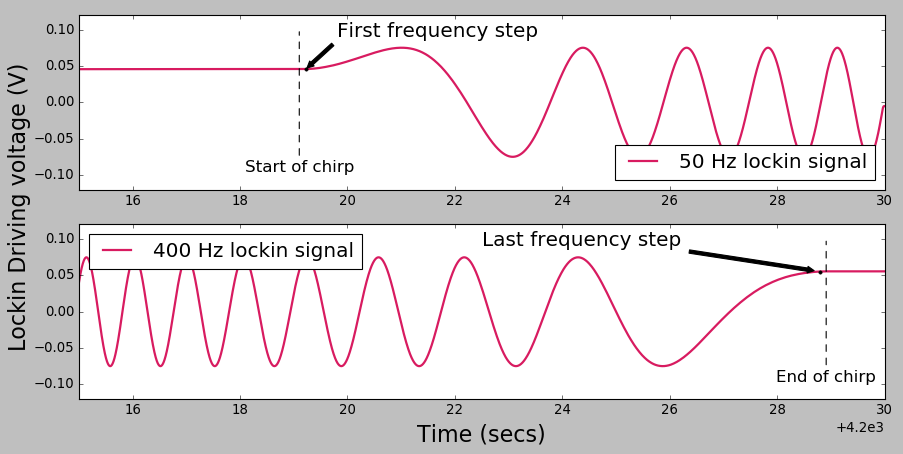

In [750]:
#the chirp data set is the recorded voltage that was used to drive 
#  the speaker, which in turn drove the system. This voltage data set
#  therefore has a very high signal to noise and is used to isolate the 
#  beginning and end of the frequency chirp
chirp = dat[:,1]

t = linspace(0,len(chirp)/10000,len(chirp))
start = 100000 #there was a noise at the beginning of the data
end = 300000 #This gives a 20 second window to find the start
             # and a 30 second window to find the end
#Cut the data into beginning and end sections
#   Know the general location of the beginning and end so there
#   is no point in performing the calculations on all the data
chirp_chunk_s = chirp[start:end] 
t_chunk_s = t[start:end]
chirp_chunk_e = chirp[-end:] 
t_chunk_e = t[-end:]
#Create reference signals for the starting and ending frequencies
# These are the same form as e^(-iwt) detailed in Equation 2.5
wave_s = cos(50*2*pi*t_chunk_s)+1j*sin(50*2*pi*t_chunk_s)
wave_e = cos(400*2*pi*t_chunk_e)+1j*sin(400*2*pi*t_chunk_e)
#Mix the cooresponding reference and signal data
lock_s = wave_s*chirp_chunk_s
lock_e = wave_e*chirp_chunk_e
#Put the mixed signals through the cooresponding low pass filters
sos_s = signal.butter(6,20,'lowpass',fs=10000,output='sos')
sos_e = signal.butter(6,100,'lowpass',fs=10000,output='sos')
filt_lock_s = signal.sosfiltfilt(sos_s,lock_s)
filt_lock_e = signal.sosfiltfilt(sos_e,lock_e)

#Points 92236 (first freq step) and 216688 (last freq step) were found by 
#  adjusting the display parameters to observe when the data stopped/started being flat
#There are 35000 frequency steps in total ((400-50)/0.01). Therefore, there
#  are 34998 steps between the first step and last step. This is used to find the 
#  amount of time between each step and then calculate the beginning and end of 
#  the frequency chirp data
x = linspace(t_chunk_s[92236],t_chunk_e[216688],34998)
dx = x[1]-x[0]
start,end = t_chunk_s[92236]-dx,t_chunk_e[216688]+dx
print('dx: ',around(x[1]-x[0],3))
print('Start time:',around(start,3))
print('End time:',around(end,3))

# fig,ax = subplots(2,1)
fig = plt.figure()
figsize(13,6)
ax,ax1,ax2 = fig.add_subplot(111,frameon=False),fig.add_subplot(211),fig.add_subplot(212)

ax1.plot(t_chunk_s,filt_lock_s,'#d81b60',linewidth=2,label='50 Hz lockin signal')
ax1.plot(t_chunk_s[92236],filt_lock_s[92236],'k.')
ax1.annotate('First frequency step', xy=(t_chunk_s[92236],filt_lock_s[92236]), 
             xytext=(19.8, 0.09),fontsize=18,
             arrowprops=dict(width=3,headwidth=6,headlength=6,facecolor='black', shrink=0.04)
              )
ax1.legend(loc=4,fontsize=18)
ax1.set_xlim(15,30)
ax1.set_ylim(-0.12,0.12)
ax2.plot(t_chunk_e,filt_lock_e,'#d81b60',linewidth=2,label='400 Hz lockin signal')
ax2.plot(t_chunk_e[216688],filt_lock_e[216688],'k.')
ax2.annotate('Last frequency step', xy=(t_chunk_e[216688], filt_lock_e[216688]), 
             xytext=(4222.5, 0.09),fontsize=18,
             arrowprops=dict(width=3,headwidth=6,headlength=6,facecolor='black', shrink=0.04)
        )
ax2.legend(loc=2,fontsize=18)
ax2.set_xlim(4215,4230)
ax2.set_ylim(-0.12,0.12)
x = linspace(t_chunk_s[92236],t_chunk_e[216688],34998)
dx = x[1]-x[0]
start,end = t_chunk_s[92236]-dx,t_chunk_e[216688]+dx

ax1.annotate('Start of chirp', xy=(start,0.1), xytext=(start, -0.09),
             fontsize=15,arrowprops = {'arrowstyle': '-', 'ls': 'dashed',
                                      'color':'k'},ha='center',va='center',
            )
ax2.annotate('End of chirp', xy=(end,0.1), xytext=(end, -0.09),
             fontsize=15,arrowprops = {'arrowstyle': '-', 'ls': 'dashed',
                                      'color':'k'},ha='center',va='center',
            )
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
grid(False)
xlabel('Time (secs)',size=20)
ax.set_ylabel('Lockin Driving voltage (V)',size=20)
ax.yaxis.labelpad=20
savefig('2020-03-13 Data seperation',transparent=True)

In [15]:
fs = 10000
# start = int(38.65*fs)
# end = int(2039.7*fs)
start = int(19.1033*fs)
end = int(4228.9092*fs)

geo = dat[start:end,0]
chirp = dat[start:end,1]
tip = lev[start:end]
print(len(geo),len(chirp),len(tip))

t = linspace(0,len(chirp)/10000,len(chirp))

42098059 42098059 42098059


Text(0, 0.5, 'Frequency Chirp (Hz)')

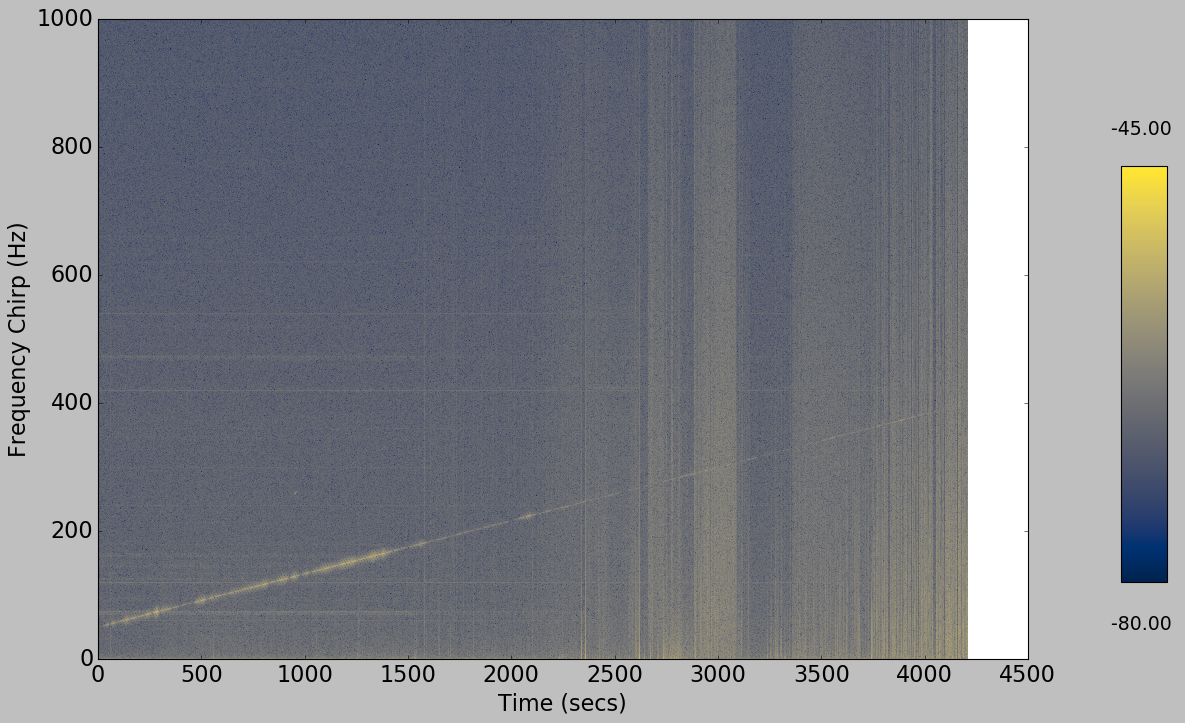

In [18]:
# figure(figsize=[20,30])
import stmpy
fig,ax = subplots(1,1)
figsize(15,10)
fs = 10000
f, t_spt, Sxx = signal.spectrogram(tip, fs,nperseg=10000)
im1 = ax.pcolormesh(t_spt,f,log(Sxx),cmap=stmpy.cm.cividis, vmin=-80,vmax=-45,rasterized=True)
# im = imshow(flip(log(Sxx),axis=0), cmap=stmpy.cm.cividis, aspect=1, clim=(-30,-5),rasterized=True)
cb = stmpy.image.add_cbar(thickness='5%',length='65%',hPos=0.98)
ax.set_ylim(0,1000)
# cb.set_label('colorbar label', color='w')
# plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='r')
# im.axes.set_xticklabels(['1','0','10','20','30','40','50'],color='w')
# im.axes.set_yticklabels(['0','50','40','30','20','10'],color='w')
im1.axes.tick_params(labelsize=20)
ax.set_xlabel('Time (secs)',size=20)
ax.set_ylabel('Frequency Chirp (Hz)',size=20)
# savefig('2020-03-13 Tip Spectrogram',transparent= True)

In [23]:
C,freqs = calibrate(geo,tip)

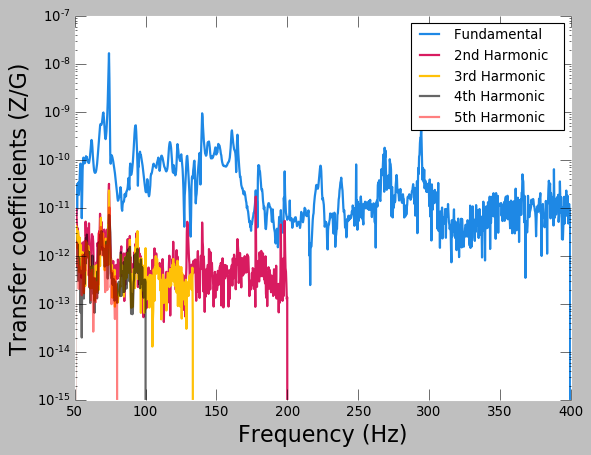

In [24]:

figsize(8,6)
fig,ax=subplots(1,1)

semilogy(freqs,(absolute(C[0](freqs))),'#1e88e5',label='Fundamental    ',linewidth=2)
semilogy(freqs,(absolute(C[1](freqs))),'#d81b60',label='2nd Harmonic',linewidth=2)
semilogy(freqs,(absolute(C[2](freqs))),'#ffc107',label='3rd Harmonic',linewidth=2)
semilogy(freqs,(absolute(C[3](freqs))),'k',label='4th Harmonic',linewidth=2,alpha=0.6)
semilogy(freqs,(absolute(C[4](freqs))),'r',label='5th Harmonic',linewidth=2,alpha=0.5)
xlim(50,400)
ylim(1e-15,1e-7)
# ylim(1e-7,1e-3)
# ylim(-35,-18)
tick_params(size= 10)
grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
xlabel('Frequency (Hz)',size=20)
ylabel('Transfer coefficients (Z/G)',size = 20)
legend(loc=1,fontsize=12)
# savefig('2020-03-13 corrected coefficients',transparent=True)

In [25]:
side = len(freqs[166:1331])
df = freqs[1]-freqs[0]
# coef_mat = log(absolute(diag(C[0](freqs[166:1331]))))
coef_mat = np.zeros((side,side),dtype='complex128')
for i,f in zip(arange(side),range(166,1331)):
    for j in arange(5):
        if (50/df)*j+(j+1)*i > side-1:
            continue
        coef_mat[int((50/df)*j+(j+1)*i),i] = (absolute(C[j](freqs[f])))
coef_mat = log(coef_mat.astype('float')+1e-55)

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


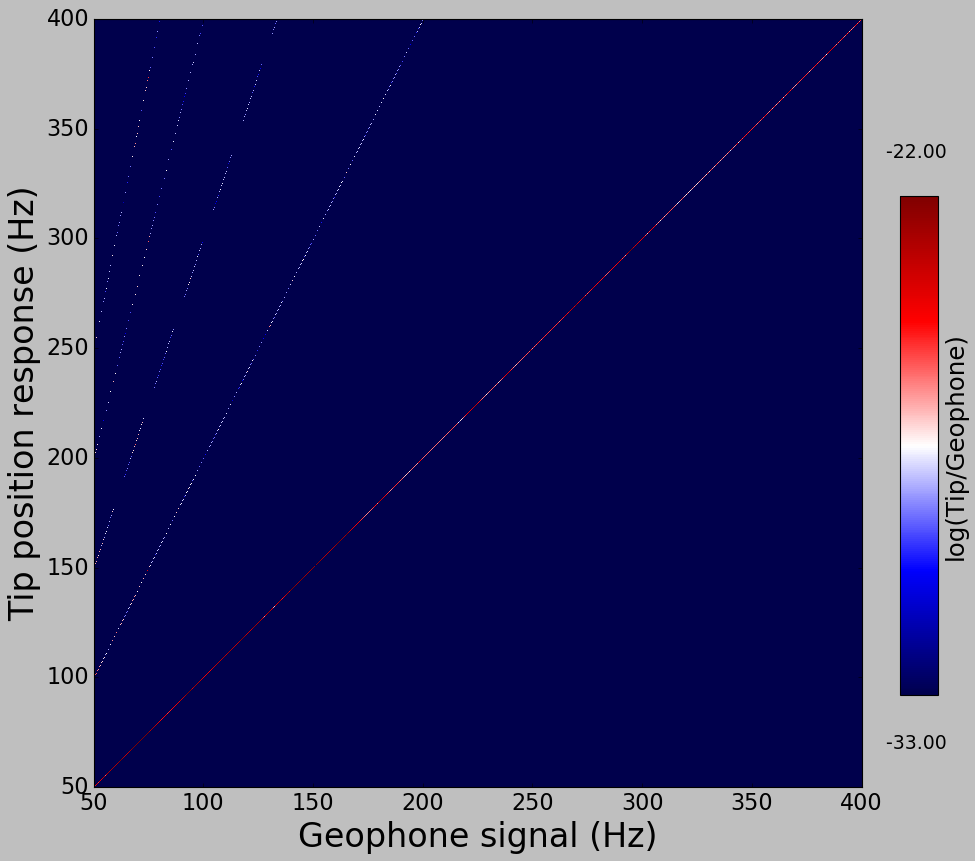

In [755]:
import stmpy
figure(figsize=[15,12])
ax = subplot(111)
im = imshow(coef_mat, cmap=stmpy.cm.seismic, aspect=1, clim=(-33,-22),
            interpolation='nearest',origin='lower',extent=[50,400,50,400])
cb = stmpy.image.add_cbar(im=im,thickness='5%',length='65%',hPos=0.93)
cb.set_label('log(Tip/Geophone)',size=22)
# plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='r')
# im.axes.set_xticklabels(['1','50','120','190','260','330','400'])
# im.axes.set_yticklabels(['0','50','120','190','260','330','400'])
im.axes.tick_params(labelsize=20)
ax.set_xlabel('Geophone signal (Hz)',size=30)
ax.set_ylabel('Tip position response (Hz)',size=30)
savefig('2020-03-13 corrected coefficient matrix',transparent=True)

In [27]:
folder_loc = '2020-03-13/Noisy Calibration Lockin 62/'
file_loc = '2020-03-13-22-14_noisy62_cal001.dat'
dat_cal = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        continue
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat_cal = np.concatenate((dat_cal,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [115]:
print(shape(dat_cal))
cur_cal = dat_cal[:,0]
geo_cal = dat_cal[:,1]
tip_cal = dat_cal[:,6]
liy_cal = dat_cal[:,8]
# geo_cal = dat_cal[:,1]

# liy_cal = dat_cal[:,10]
t_cal = linspace(0,len(geo_cal)/10000,len(geo_cal))

(3916000, 9)


Text(0, 0.5, 'Frequency Chirp (Hz)')

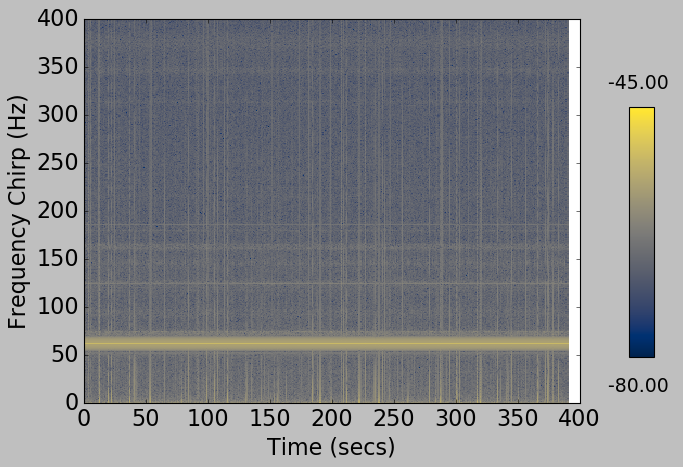

In [29]:
# figure(figsize=[20,30])
fig,ax = subplots(1,1)
figsize(15,10)
fs = 10000
f, t_spt, Sxx = signal.spectrogram(tip_cal, fs,nperseg=10000)
im1 = ax.pcolormesh(t_spt,f,log(Sxx),cmap=stmpy.cm.cividis, vmin=-80,vmax=-45,rasterized=True)
# im = imshow(flip(log(Sxx),axis=0), cmap=stmpy.cm.cividis, aspect=1, clim=(-30,-5),rasterized=True)
cb = stmpy.image.add_cbar(thickness='5%',length='65%',hPos=0.98)
ax.set_ylim(0,400)
# cb.set_label('colorbar label', color='w')
# plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='r')
# im.axes.set_xticklabels(['1','0','10','20','30','40','50'],color='w')
# im.axes.set_yticklabels(['0','50','40','30','20','10'],color='w')
im1.axes.tick_params(labelsize=20)
ax.set_xlabel('Time (secs)',size=20)
ax.set_ylabel('Frequency Chirp (Hz)',size=20)
# savefig('2020-03-13 Tip Spectrogram',transparent= True)

Text(0, 0.5, 'Frequency Chirp (Hz)')

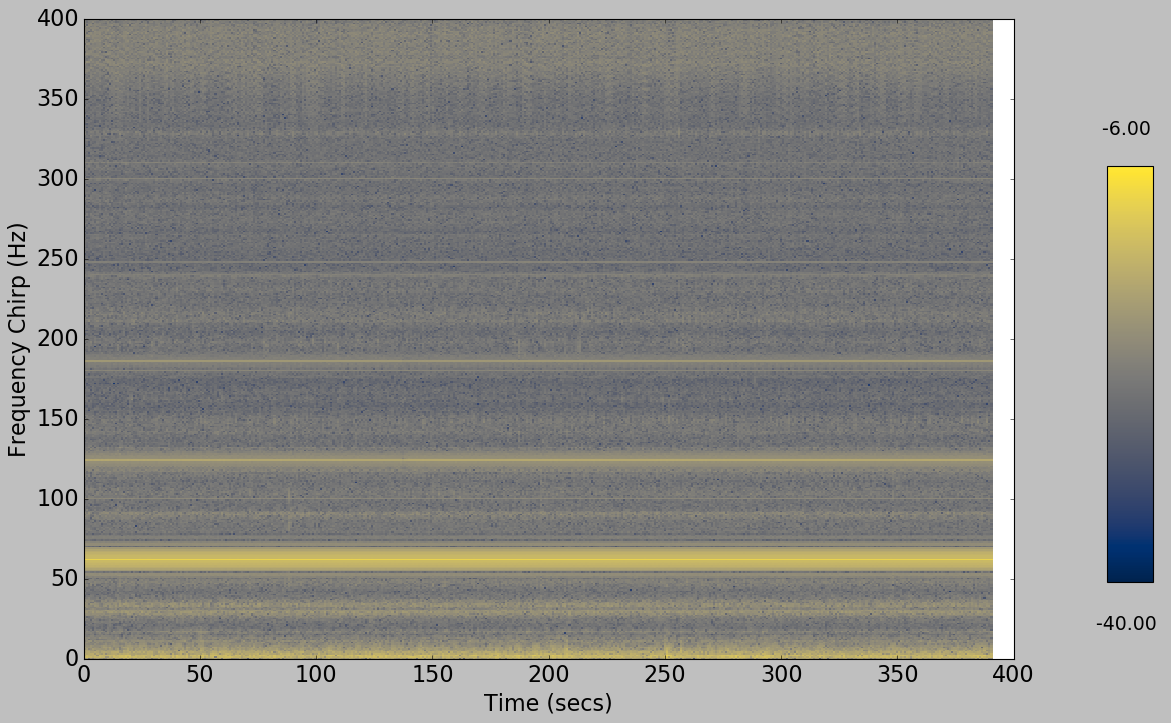

In [30]:
# figure(figsize=[20,30])
fig,ax = subplots(1,1)
figsize(15,10)
fs = 10000
f, t_spt, Sxx = signal.spectrogram(geo_cal, fs,nperseg=10000)
im1 = ax.pcolormesh(t_spt,f,log(Sxx),cmap=stmpy.cm.cividis, vmin=-40,vmax=-6,rasterized=True)
# im = imshow(flip(log(Sxx),axis=0), cmap=stmpy.cm.cividis, aspect=1, clim=(-30,-5),rasterized=True)
cb = stmpy.image.add_cbar(thickness='5%',length='65%',hPos=0.98)
ax.set_ylim(0,400)
# cb.set_label('colorbar label', color='w')
# plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='r')
# im.axes.set_xticklabels(['1','0','10','20','30','40','50'],color='w')
# im.axes.set_yticklabels(['0','50','40','30','20','10'],color='w')
im1.axes.tick_params(labelsize=20)
ax.set_xlabel('Time (secs)',size=20)
ax.set_ylabel('Frequency Chirp (Hz)',size=20)
# savefig('2020-03-13 Tip Spectrogram',transparent= True)

In [454]:
def segment(data,n,o,b=5):
    '''
    This function segments the data into predetermined pieces
    
    Inputs:
        data - Required: 1D numpy array of data to be segmented
        n    - Required: length of segment data is pieced into
        o    - Required: length of overlap between segments 
        b    - Optional: Beta parameter used by the Kaiser function;
                     the default = 5 makes it similar to a Hamming window
    
    Returns:
        seg  - 2D array size(data-o//n-o,n) of the input data
    '''
    #Initialize a 2D array with the number of rows being how many segments
    #   can be created from data of length 'n' and columns of length 'n'
    seg = np.zeros(((len(data)-o)//(n-o),n),dtype=np.complex)
    temp = np.copy(data)
    i = 0
    #Parce through data, seperating the segments into different rows
    #This does not utilize all the data, only up length divisible by n
    #Break out of the while loop once only the surplus data remains
    while len(temp) >= n:
        #Remove any dc offset or 2nd degree polynomial drift
        #  from the segmented data and save it to the designated row
        seg[i,:] = fit_cancel(temp[:n])*np.kaiser(n,b)
        i += 1 #iterate to the next row
        temp = temp[n-o:] #Redefine the data set, removing the last 
                          #  segmented piece of data minus the overlap
    return seg

def avg_fft(data,n,o,b=5,fs=10000):
    '''
    The Fourier transform of the data, in entirety, is quite noisy.
    This function uses the segment function to break the data into manageable pieces, 
    averaging the Fourier transform of each segment together to reduce that noise. 
    This reduces incoherent signals and random flucuations in coherent ones.
    
    Inputs:
        data - Required: 1D numpy array of data to be segmented
        n    - Required: length of segment data is pieced into
        o    - Required: length of overlap between segments 
        b    - Optional: Beta parameter used by the Kaiser function;
                     the default = 5 makes it similar to a Hamming window
        fs   - Optional: int stating sampling rate of data collection
    
    Returns:
        seg  - fft of length n 
        freqs- frequencies the make up the fft
    '''
    #Call the segment function to parce through data
    seg = segment(data,n,o,b)
    #Calculate the Fourier transform of each row in the 2D array
    seg = fft.fft(seg,axis=1)
    #Average the Fourier transforms together
    seg = mean(seg,axis=0)
    #Calculate the corresponding frequencies 
    freqs = fft.fftfreq(len(seg),1/fs)
    return seg,freqs

# n = 10000
# c = liy_cal[:int(300*fs)]
# seg_c = np.zeros(((len(c))//(n),n),dtype=np.complex)
# c_cal_temp = np.copy(c)
# j = 0
# while len(c_cal_temp) >= n:
#     seg_c[j,:] = fit_cancel(c_cal_temp[:n])
#     j+=1
#     c_cal_temp = c_cal_temp[n:]
    
# for i in range(0,len(seg_c[:,0])):
#     seg_c[i,:] = np.fft.fft(seg_c[i,:])
    
# seg_c = mean(seg_c,axis=0)

# freqs = np.fft.fftfreq(len(s),1/10000)


In [535]:
n=200000
o=0
s1 = int(300*fs)
s2 = int(380*fs)
#average the fft of the calibration data to reduce noise
alias_fft,frq_a = avg_fft(liy_cal[:s1],n,o)
#initiate the shape of the aliasing transfer function
A = np.zeros(len(alias_fft),dtype='complex128')
#this is the modulation frequency
w_mod = 1000
#take the Fourier transform of the test data
fft_c = fft.fft(liy_cal[s1:s2])
#Find its corresponding frequencies
frq_c = np.fft.fftfreq(len(fft_c),1/10000)
print(nearest(frq_c,w_mod))
#bin location of the modulation frequency
#  in the calibration data
mod_loc = nearest(frq_a,w_mod)
#implement Equation 2.15 to find the alias transfer function
for i,frq in enumerate(frq_a[:int(len(alias_fft)/2)]):
    if i == mod_loc:
        continue
    A[i] = alias_fft[absolute(i-mod_loc)]/alias_fft[i]
#Interpolate the array so that it can be called easier
A = scipy.interpolate.interp1d(frq_a,A,kind='linear',fill_value='extrapolate')
#Initiate the estimation array
c_alias = np.zeros(len(fft_c),dtype='complex128')
#bin location of the modulation frequency
# in the test data
mod_loc = nearest(frq_c,w_mod)
#Iterate through all frequencies up to 2 times the modulation 
#  frequency to determine the estimated aliasing impact
for i in arange(int(2*mod_loc)):
    c_alias[i] = A(frq_c[absolute(mod_loc-i)])*fft_c[absolute(mod_loc-i)]
#Positive and negative frequencies must be complex conjugates for the inverse
#  Fourier transform to result in a real value
c_alias[int(len(c_alias)/2):] = np.flip(conj(c_alias[:int(len(c_alias)/2)]))




80000


(0, 1300)

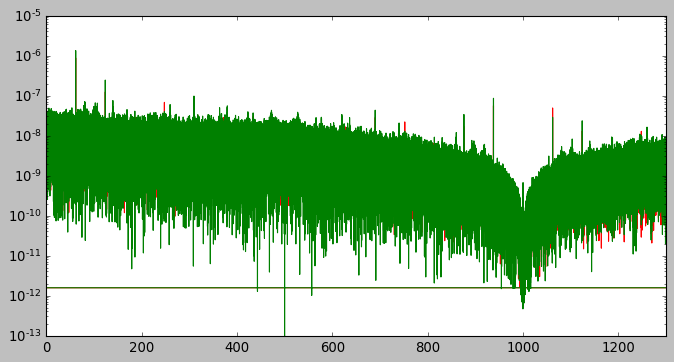

In [536]:
# semilogy(frq_a, absolute(A(frq_a)))
# semilogy(frq_a,absolute(alias_fft),'k')
# semilogy(frq_c,absolute(fft_c-c_alias))
semilogy(frq_c,absolute(fft_c),'r')
# semilogy(frq_c,absolute(c_alias),'b')
semilogy(frq_c,absolute(fft_c-c_alias),'g')
ylim(1e-13,1e-5)
xlim(0,1300)

(1.0, 1000000.0)

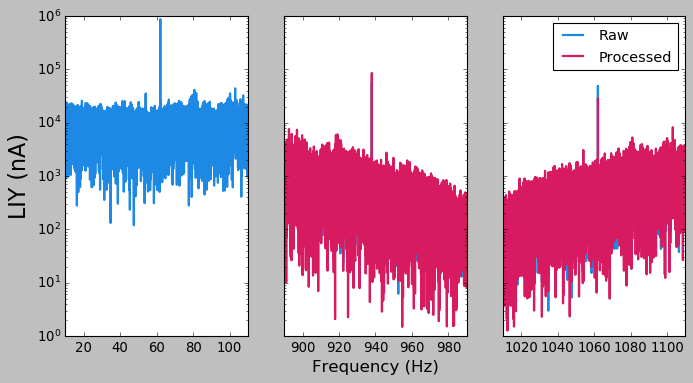

In [537]:

fig,ax = subplots(1,3)
figsize(10,5)
ax[0].semilogy(frq_c[:int(len(fft_c)/2)],
               absolute(1e12*fft_c[:int(len(fft_c)/2)]),
               '#1e88e5',linewidth=2)
ax[1].semilogy(frq_c[:int(len(fft_c)/2)],
               absolute(1e12*fft_c[:int(len(fft_c)/2)]),
               '#1e88e5',linewidth=2)
ax[2].semilogy(frq_c[:int(len(fft_c)/2)],
               absolute(1e12*fft_c[:int(len(fft_c)/2)]),
               '#1e88e5',label='Raw',linewidth=2)


ax[1].semilogy(frq_c[:int(len(fft_c)/2)],
               absolute(1e12*fft_c[:int(len(fft_c)/2)]-
                       1e12*c_alias[:int(len(fft_c)/2)]),
               '#d81b60',linewidth=2)
ax[2].semilogy(frq_c[:int(len(fft_c)/2)],
               absolute(1e12*fft_c[:int(len(fft_c)/2)]-
                       1e12*c_alias[:int(len(fft_c)/2)]),
               '#d81b60',label='Processed',linewidth=2)

ax[1].set_xlabel('Frequency (Hz)',size=15)
ax[0].set_ylabel('LIY (nA)',size=20)
ax[1].tick_params(axis='y',labelleft=False)
ax[2].legend(loc=0,fontsize=13)
ax[2].tick_params(axis='y',labelleft=False)
ax[0].set_xlim(10,110)
ax[1].set_xlim(890,990)
ax[2].set_xlim(1010,1110)
ax[0].set_ylim(1e0,1e6)
ax[1].set_ylim(1e0,1e6)
ax[2].set_ylim(1e0,1e6)
# savefig('2020-4-10 Spectroscopic aliasing',transparent=True)

In [34]:
#Calculate the Fourier transform of the geophone test signal
#   *In this case the test data is the last 80 seconds of the 
#    driven data set
G = fft.fft(geo_cal[3000000:3800000])
omega = fft.fftfreq(len(geo_cal[3000000:3800000]),1/10000)
#Save that tranform as an interpolation object for easier callback
G = scipy.interpolate.interp1d(omega,G,kind='linear',fill_value='extrapolate')

In [35]:
print(len(C[:]))

5


In [724]:
#Calculate the Fourier transform of the measured geophone data
#   *In this case the test data is the last 80 seconds of the 
#    driven data set
g_test = geo_cal[3000000:3800000]
z_test = tip_cal[3000000:3800000]
G_m = fft.fft(g_test)
omega = fft.fftfreq(len(g_test),1/10000) #find the corresponding frequencies
#Interpolate the geophone frequency signal 
#  The harmonic calculation does not usually fall onto specific frequency bins,
#  the interpolation estimates the coefficient value if it falls between points
G_m = scipy.interpolate.interp1d(omega,G_m,kind='linear',fill_value='extrapolate')

z_noise = np.zeros(len(omega),dtype='complex128') #initialize noise array

#Use the coefficients and interpolated geophone signal to estimate z_noise
for i in arange(len(C[:])):
    n = i+1
    #Sum the impact that each harmonic has on the signal (Equation 2.4)
    z_noise += C[i](omega/n)*G_m(omega/n)
#Find the signal by subtracting noise from measured data (Equation 2.8)
z_sig = z_test - fft.ifft(z_noise)


In [725]:
#Implement Equation 
# tip_omega = C[0](omega)*G(omega) + C[1](omega/2)*G(omega/2) + \
#     C[2](omega/3)*G(omega/3) + C[3](omega/4)*G(omega/4)
# tip_vib = fft.ifft(tip_omega)
# print(tip_vib)

In [726]:
#Use the program Albert Chen wrote to calculate the transfer function for
#  the vector cancellation scheme and use the geophone test data to 
#  estimate the noise
tip_cal = fit_cancel(dat_cal[:,6])
s,e = 3000000,3800000
g_cal,z_cal,g_test,z_test = geo_cal[:s],cur_cal[:s],geo_cal[s:e],cur_cal[s:e]

import cancelv3 as cancel
tf = cancel.Cancel(g_cal-mean(g_cal),z_cal,1/10000,p=[200000,50000,5])
z_noise_vec  = tf.create_drive(g_test-mean(g_test))
z_sig_vec = z_test - z_noise_vec #Subtract the noise from the measured tip data

(300, 300.1)

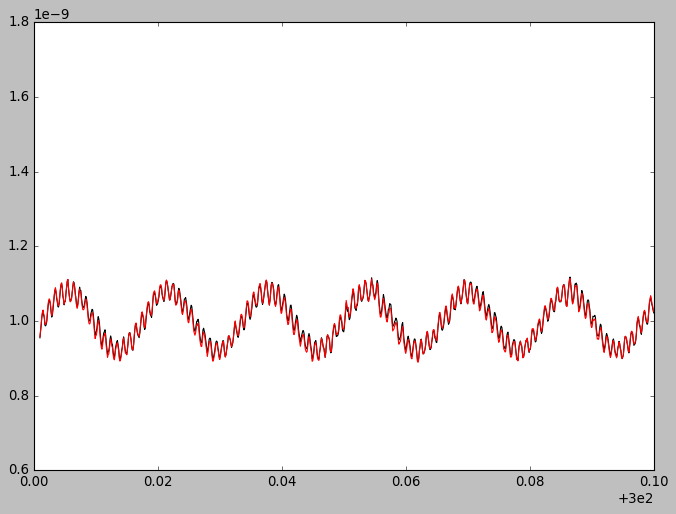

In [138]:
# kappa = -24929385877.175434
kappa = -34715365715.10908

cur_noise_test = exp(-kappa*(z_noise_vec-mean(z_noise_vec)))
delay = 10
int_cur_noise =repeat(np.mean(cur_noise_test.reshape(-1, 10), axis=1),10)
cur_canc = cur_cal[s:e]-z_noise_vec[:]
int_liy_canc = liy_cal[s:e]/int_cur_noise
# plot(t[s:e],liy_cal[s:e])
# plot(t[s:e],int_liy_canc)
plot(t[s+delay:e],cur_cal[s+delay:e],'k')
plot(t[s+delay:e],cur_canc[delay:],'r')
# plot(t[s:e],cur_noise_test)
# plt(t[s])
# plot(t[:s],z_cal[:s])
# plot(t[s:e],z_sig_vec)
xlim(300,300.1)
# ylim(0,0.5e-10)

(1e-10, 0.0001)

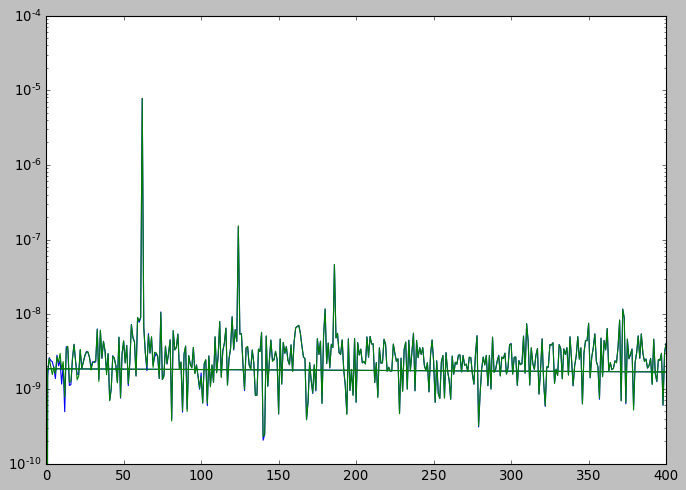

In [118]:
n = 200000
o = 50000
b = 5
# z_fft,freqs = avg_fft(z_test,n,o,b)
fft_cur, frq = avg_fft(cur_cal[s:e],n,o,b)
fft_cur_canc, frq = avg_fft(cur_canc,n,o,b)
fft_liy,frq = avg_fft(liy_cal[s:e],n,o,b)
fft_int_canc,frq = avg_fft(int_liy_canc,n,o,b)
# frq = fft.fftfreq(len(liy_cal[s:e]),1/10000)
# semilogy(frq,abs(fft_liy))
# semilogy(frq,abs(fft_int_canc))
semilogy(frq[::20],abs(fft_cur[::20]))
semilogy(frq[::20],abs(fft_cur_canc[::20]))
xlim(0,400)
ylim(1e-10,1e-4)

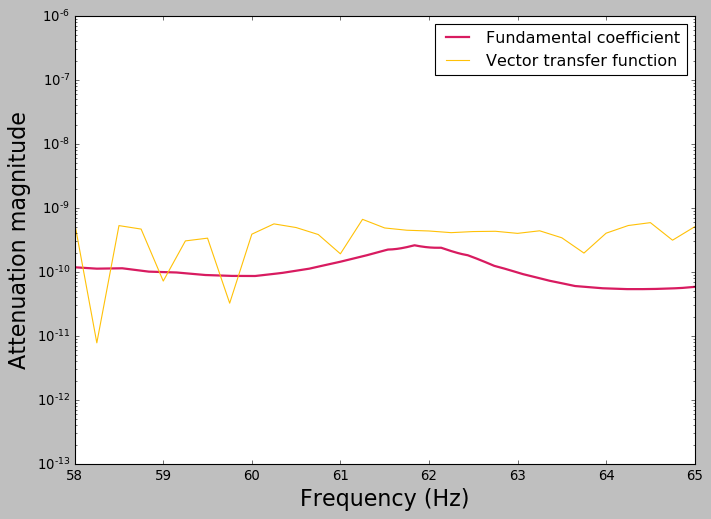

In [143]:
fund_coef = C[0](omega)
semilogy(omega,absolute(fund_coef),'-', 
         color='#d81b60', lw=2,label='Fundamental coefficient')
semilogy(tf.freqs[:int(len(tf.freqs)/2):5],
         absolute(tf.transf(tf.freqs[:int(len(tf.freqs)/2):5])), 
         color='#ffc107',label='Vector transfer function')

xlabel('Frequency (Hz)',size=20)
ylabel('Attenuation magnitude',size=20)
legend(loc=0)
xlim(58,65)
# xlim(50,400)
ylim(1e-13,1e-6)
savefig('Vector vs Fundamental transfer',transparent =True)

In [42]:
def cancel_skips(array, tol):
    data = array[15:]-array[:-15]
    markers = where(abs(data)>=tol)*sign(data)[where(abs(data)>=tol)]
    result = array[0:abs(int(markers[0][0]))]
    counter=markers[0][0]
    gap = 0
    for idx in markers[0]:
        if (counter*idx) < 1:
            result = concatenate((result,array[abs(int(counter)):abs(int(idx))]-gap))
            counter = idx
            gap = 0
        else:
            if markers[0][0] > 0: gap = max(gap,data[abs(int(idx))])
            else: gap = min(gap,data[abs(int(idx))])
    if shape(array) is not shape(result):
        result = concatenate((result,array[abs(int(counter)):]-gap))
    return result

cal_test = cancel_skips(tip_cal[2900000:3400000],4e-12)
tip_temp = tip_cal[2900000:3400000]
# plot(1e12*(tip_temp-mean(tip_temp)))
# plot(absolute(tip_temp[15:]-tip_temp[:-15])*1e12,alpha=0.8)
# plot(1e12*(cal_test-mean(cal_test)),alpha=0.8)
# ylim(-1,20)

In [43]:
# tip_sig = tip_cal[2900000:3400000-10]-tip_vib[10:]
# z_sig_vec = tip_cal[3000000:3800000]-z_noise_vec
# print((tip_cal[2900000:3400000-10])-tip_vib[10:])
# print(tip_sig)

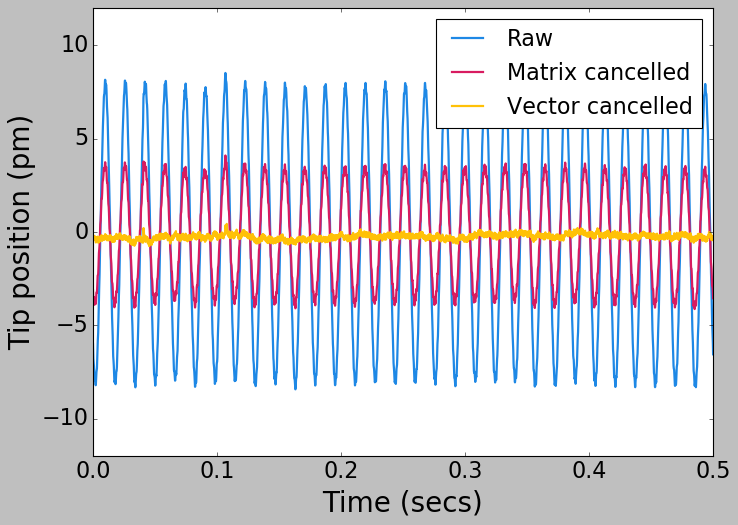

In [44]:
figsize(10,7)
fs =10000
start = 300*fs
end = 380*fs
#Plot the raw and cancelled data sets
#  *The '-5' is used to center the signal about zero pm
#  ** The '-321' is used to center the displayed signal about 0 secs
plot(t_cal[start:end]-321,1e12*(z_test-mean(z_test))-5,
     '#1e88e5',linewidth=2,label='Raw')
plot(t_cal[start:end]-321,1e12*(z_sig.real-mean(z_sig.real))-5,
     '#d81b60',linewidth=2,label='Matrix cancelled')
plot(t_cal[start:end]-321,1e12*(z_sig_vec.real-mean(z_sig_vec.real))-5,
     '#ffc107',linewidth=2,label='Vector cancelled')
xlim(0,0.5)
ylim(-12,12)
tick_params(labelsize=20)
xlabel('Time (secs)',size=25)
ylabel('Tip position (pm)',size=25)
legend(loc=1,fontsize=20)
grid(False)


savefig('2020-4-8 matrix vector cancellation',transparent=True)

In [45]:
# rms_raw = np.zeros(int(len(tip_sig[310000:])/20000),dtype='complex128')
# rms_mat = np.zeros(int(len(tip_sig[310000:])/20000),dtype='complex128')
# rms_vec = np.zeros(int(len(tip_sig[310000:])/20000),dtype='complex128')
# prev=310000
# print(shape(tip_sig),shape(tip_cal),shape(tip_sig_vec))
# for i in arange(int(len(tip_sig[310000:])/20000)):
#     point = prev+20000
#     rms_raw[i] = sqrt(mean((fit_cancel(tip_cal[prev:point]))**2))
#     rms_mat[i] = sqrt(mean((fit_cancel(tip_sig[prev:point]))**2))
#     rms_vec[i] = sqrt(mean(((tip_sig_vec[prev:point]-mean(tip_sig_vec[prev:point])))**2))
#     prev=point
# canc_mat = 100-100*rms_mat.astype('float')/rms_raw.astype('float')
# canc_vec = 100-100*rms_vec.astype('float')/rms_raw.astype('float')
# print(i)
# print('Mean Matrix:',mean(canc_mat))
# print('STD Matrix: ',std(canc_mat))
# print('Mean Vector:',mean(canc_vec))
# print('STD Vector:',std(canc_vec))
# print(len(t_cal[start+300000:end:10000]))
# plot(t_cal[start+310000:end:10000],rms_raw,'#1e88e5',label='Raw')
# plot(t_cal[start+310000:end:10000],rms_mat,'#d81b60',label='Matrix')
# plot(t_cal[start+310000:end:10000],rms_vec,'#ffc107',label='Vector')
# tick_params(labelsize=20)
# ylabel('RMS values',size=25)
# plot(canc_mat,'k',label='Matrix Cancellation')
# plot(canc_vec,'r',label='Vector Cancellation')
# legend(loc=0)

In [46]:
rms_r = sqrt(mean(fit_cancel(z_test[210000:215000])**2))
rms_m = sqrt(mean(fit_cancel(z_sig[210000:215000])**2))
rms_v = sqrt(mean(fit_cancel(z_sig_vec[210000:215000])**2))
print(100-100*(rms_m/rms_r))
print(100-100*(rms_v/rms_r))

(54.39111050631279+8.922328217734717e-15j)
(97.36905956340846-8.750012431705273e-09j)


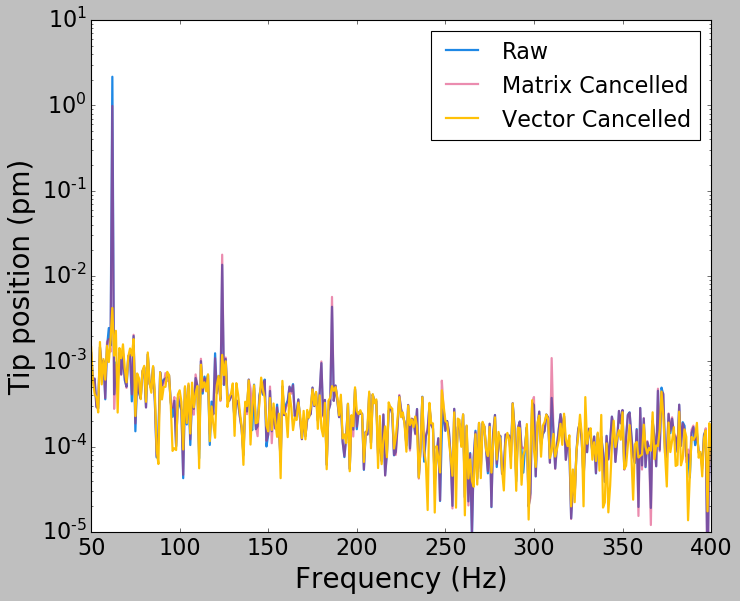

In [721]:

#Calculate the Fourier transform of the raw and cancelled signals
n = 200000
o = 50000
b = 5
z_fft,freqs = avg_fft(z_test,n,o,b)
z_mat_fft,freqs_m = avg_fft(z_sig,n,o,b)
z_vec_fft,freqs_v = avg_fft(z_sig_vec,n,o,b)
z_noise_fft,freqs_n = avg_fft(fft.ifft(z_noise),n,o,b)
z_noise_vec_fft,freqs_nv = avg_fft((z_noise_vec),n,o,b)
#Plot all three data sets on a logarithmic plot
sk = 20
semilogy(freqs[:int(len(z_fft)/2):sk],
       1e12*absolute(z_fft[:int(len(z_fft)/2):sk])/n,
       '#1e88e5',label='Raw',linewidth=2)
semilogy(freqs_m[:int(len(z_mat_fft)/2):sk],
       1e12*absolute(z_mat_fft[:int(len(z_mat_fft)/2):sk])/n,
       '#d81b60',label='Matrix Cancelled',linewidth=2,alpha=0.5)
semilogy(freqs_v[:int(len(z_vec_fft)/2):sk],
       1e12*absolute(z_vec_fft[:int(len(z_vec_fft)/2):sk])/n,
       '#ffc107',label='Vector Cancelled',linewidth=2)

legend(loc=0,fontsize=20)
tick_params(labelsize=20)
xlabel('Frequency (Hz)',size=25)
ylabel('Tip position (pm)',size=25)
xlim(50,400)
ylim(1e-5,1e1)
savefig('2020-5-2 topo cancellation freq',transparent=True)

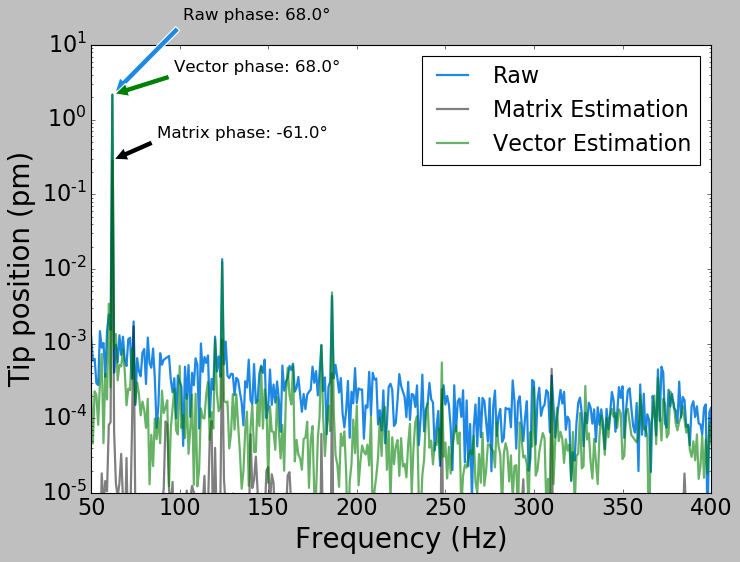

In [542]:
#Calculate the Fourier transform of the raw and cancelled signals
n = 200000
o = 50000
b = 5
z_fft,freqs = avg_fft(z_test,n,o,b)
z_noise_fft,freqs_n = avg_fft(fft.ifft(z_noise),n,o,b)
z_noise_vec_fft,freqs_nv = avg_fft((z_noise_vec),n,o,b)
z_fft,z_noise_fft,z_noise_vec_fft = (
    1e12*z_fft/n,1e12*z_noise_fft/n,1e12*z_noise_vec_fft/n)
freq_loc = 1240  #The bin number for the frequency by which i am specifically
                 #   calculating the phase of
deg_sign= u'\N{DEGREE SIGN}' #This is just the code to create a degree sign string
#Create strings to display on the plot
#  Calculating the phase of signal at freq_loc
raw_phase = 'Raw phase: '+ str(around(180*angle(
    z_fft[freq_loc])/(2*pi))) +deg_sign
mat_phase = 'Matrix phase: '+ str(around(180*angle(
    z_noise_fft[freq_loc])/(2*pi))) + deg_sign
vec_phase = 'Vector phase: '+ str(around(180*angle(
    z_noise_vec_fft[freq_loc])/(2*pi))) + deg_sign

#Plot the fft and strings on a loglog plot
fig,ax = subplots(1,1)
figsize(10,7)
ax.semilogy(freqs[:int(len(z_fft)/2):sk],
       absolute(z_fft[:int(len(z_fft)/2):sk]),
       '#1e88e5',label='Raw',linewidth=2)
#This just adds an arrow pointed at the freq_loc location
ax.annotate(raw_phase, xy=(freqs[freq_loc],abs(z_fft[freq_loc])), 
            xytext=(freqs[freq_loc+800],10*abs(z_fft[freq_loc])),
            fontsize=15,arrowprops=dict(
                width=5,headwidth=12,headlength=12,edgecolor='w',
                facecolor='#1e88e5', shrink=0.04)
              )
ax.semilogy(freqs_n[:int(len(z_noise_fft)/2):sk],
       absolute(z_noise_fft[:int(len(z_noise_fft)/2):sk]),
       'k',label='Matrix Estimation',linewidth=2,alpha=0.5)
ax.annotate(mat_phase, xy=(freqs_n[freq_loc],abs(z_noise_fft[freq_loc])), 
            xytext=(freqs_n[freq_loc+500], 2*abs(z_noise_fft[freq_loc])),
            fontsize=15,arrowprops=dict(
                width=5,headwidth=12,headlength=12,edgecolor='w',
                facecolor='k', shrink=0.04)
              )
ax.semilogy(freqs_nv[:int(len(freqs_nv)/2):sk],
       absolute(z_noise_vec_fft[:int(len(z_noise_vec_fft)/2):sk]),
       'g',label='Vector Estimation',linewidth=2,alpha=0.6)
ax.annotate(vec_phase, xy=(freqs_nv[freq_loc],abs(z_noise_vec_fft[freq_loc])), 
            xytext=(freqs_nv[freq_loc+700], 2*abs(z_noise_vec_fft[freq_loc])),
            fontsize=15,arrowprops=dict(
                width=5,headwidth=12,headlength=12,edgecolor='w',
                facecolor='g', shrink=0.04)
              )

ax.legend(loc=0,fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlabel('Frequency (Hz)',size=25)
ax.set_ylabel('Tip position (pm)',size=25)
ax.set_xlim(50,400)
ax.set_ylim(1e-5,1e1)
savefig('2020-5-2 noise est freq',transparent=True)

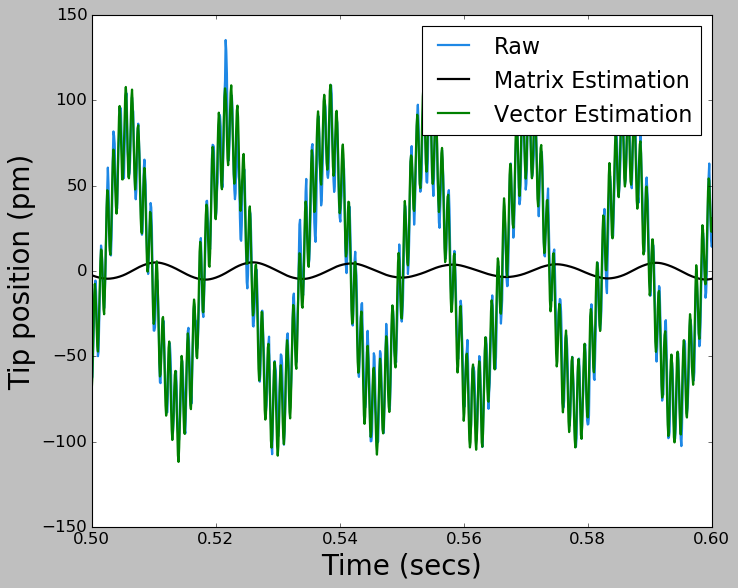

In [743]:
plot(t_cal[s:e]-300,1e12*(z_test-mean(z_test)),
     '#1e88e5',label='Raw',linewidth=2)
plot(t_cal[s:e]-300,1e12*fft.ifft(z_noise),
     'k',label='Matrix Estimation',linewidth=2)
plot(t_cal[s:e]-300,1e12*z_noise_vec,
     'g',label='Vector Estimation',linewidth=2)
xlim(0.5,0.6)
ylim(-150,150)
legend(loc=1,fontsize=20)
tick_params(labelsize=15)
xlabel('Time (secs)',size=25)
ylabel('Tip position (pm)',size=25)
savefig('2020-03-13 Noise phase issue',transparent=True)

Mean Matrix: 52.576207110423674
STD Matrix:  3.427723911612026
Mean Vector: 85.93510248849178
STD Vector: 10.717590225954899


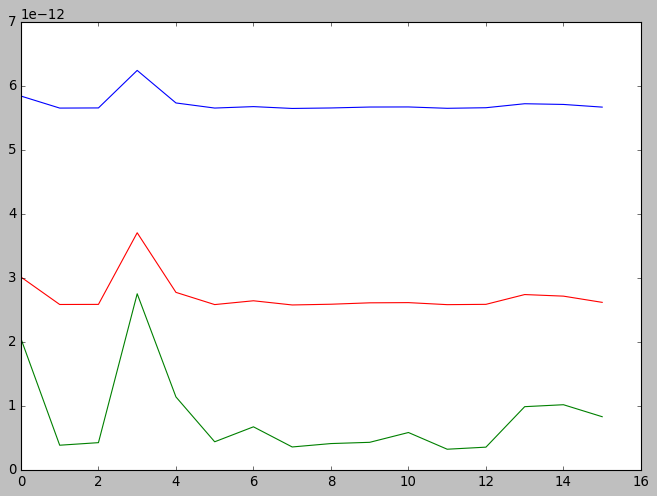

In [49]:
#Segment the raw and cancelled data into sections of 5 seconds
n=50000
#Use the segment function to do this with overlap = 0
seg_raw,seg_mat,seg_vec = \
segment(z_test,n,0),segment(z_sig,n,0),segment(z_sig_vec,n,0)
#Calculate the rms value of each of the 2 sec segments
rms_raw,rms_mat,rms_vec = \
zeros(len(seg_raw[:,0])),zeros(len(seg_raw[:,0])),zeros(len(seg_raw[:,0]))
for i in arange(len(seg_raw[:,0])):
    rms_raw[i] = absolute(sqrt(mean((seg_raw[i,:]-mean(seg_raw[i,:]))**2)))
    rms_mat[i] = absolute(sqrt(mean((seg_mat[i,:]-mean(seg_mat[i,:]))**2)))
    rms_vec[i] = absolute(sqrt(mean((seg_vec[i,:]-mean(seg_vec[i,:]))**2)))
#Calculate the percent reduction that matrix and vector schemes achieve
canc_mat = 100-100*rms_mat.astype('float')/rms_raw.astype('float')
canc_vec = 100-100*rms_vec.astype('float')/rms_raw.astype('float')
print('Mean Matrix:',mean(canc_mat))
print('STD Matrix: ',std(canc_mat))
print('Mean Vector:',mean(canc_vec))
print('STD Vector:',std(canc_vec))
plot(rms_raw)
plot(rms_vec)
plot(rms_mat)
# plot(canc_vec)
# plot(canc_mat)
# plot(0*canc_mat+41.96)
# plot(0*canc_vec+85.9)

In [487]:
print(scipy.stats.ttest_rel(rms_raw,rms_mat))
print(scipy.stats.ttest_rel(rms_raw,rms_vec))


Ttest_relResult(statistic=112.50400197974709, pvalue=2.27088676357076e-23)
Ttest_relResult(statistic=35.739702437688806, pvalue=6.227161559960352e-16)


(50, 400)

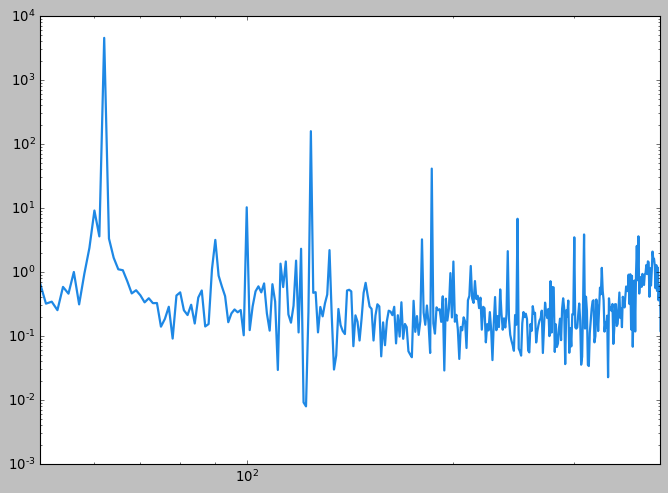

In [491]:
geo_fft = fft.fft(geo_cal[2900000:3400000])
loglog(freqs2[:int(len(tip_fft)/2):50],absolute(geo_fft[:int(len(tip_fft)/2):50]),
         '#1e88e5',label='Raw',linewidth=2)
xlim(50,400)

In [145]:
folder_loc = '2020-03-13/Spec Sweep Noisy 62/'
file_loc = '2020-03-13-20-57_spec_noisy2001.dat'

dat_spec = np.loadtxt(folder_loc+file_loc,skiprows=76)

for filename in os.listdir(folder_loc):
    if filename == file_loc:
        pass
    try:
        tempdata = np.loadtxt(folder_loc+filename, skiprows=76)
        dat_spec = np.concatenate((dat_spec,tempdata))
        print(filename,end='\r')
    except:
        print('ERROR: ',filename)

In [478]:
cur = dat_spec[:,0]
geo = dat_spec[:,1]
speaker = dat_spec[:,2]
bias_mod = dat_spec[:,4]
bias = dat_spec[:,5]
Z = dat_spec[:,6]
LIY = dat_spec[:,8]

t = linspace(0,len(cur)/10000,len(cur))
print(len(cur),len(t),shape(dat_spec))
print(t[1])

7583000 7583000 (7583000, 9)
0.00010000001318739458


500


(740, 780)

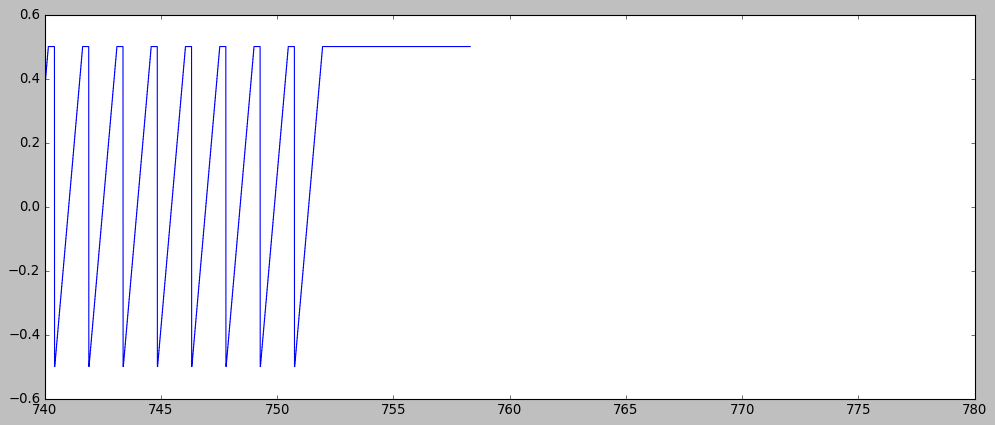

In [481]:
figsize(15,6)


dt = t[1] #The change in time during data collection
grad = np.gradient(bias,dt)
#Identify the location of the top 20000 gradient values
brk_pnt = np.flip(np.argsort(absolute(grad)))[:2000]
count = 0
#Iterate through all the breakpoints
# Find out how many of the 2000 are valid
for j in brk_pnt:
    if absolute(grad[j]) > 1000:
        count = count+1

#Redefine the top count gradient values
brk_pnt = np.flip(np.argsort(absolute(grad)))[:count]
#Order the values by location
brk_pnt = np.flip(np.sort(brk_pnt))
#Iterate through the locations and set any close 
#  neighbors to 0
for idx,point in enumerate(brk_pnt):
    temp_pnt = point
    #Set locations in array close to the point to 0
    brk_pnt[np.where(absolute(brk_pnt-point)<10)] = 0
    #This includes the point itself so
    #  redefine the point value
    brk_pnt[idx] = point

#Remove any locations that were set to 0
brk_pnt = np.sort(brk_pnt[brk_pnt != 0])
print(len(brk_pnt))
plot(t,bias)
grid(False)
# plot(t,grad)
start = 0
xlim(740,780)
# ylim(-5009,-4900)

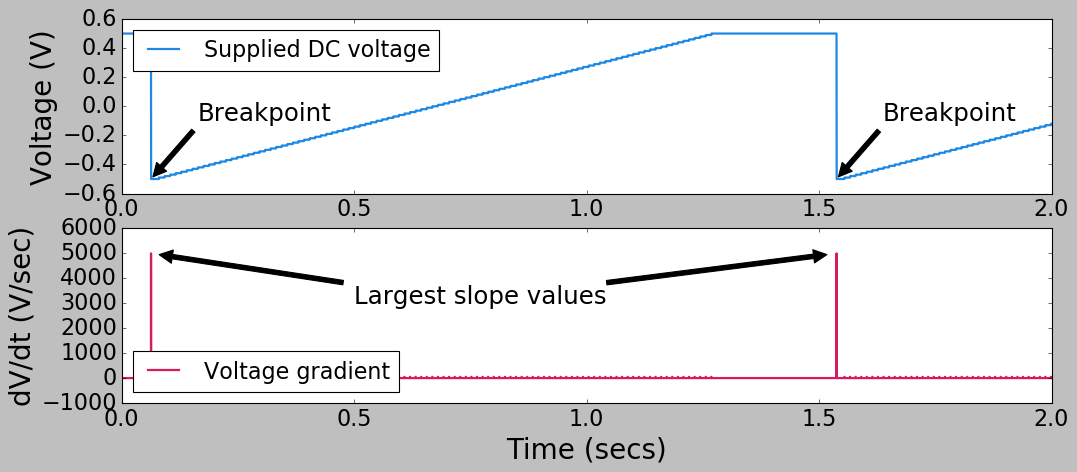

In [148]:
fig,ax = subplots(2,1)
figsize(15,10)
ax[0].plot(t-15,bias,'#1e88e5',linewidth=2,label='Supplied DC voltage')
ax[0].annotate('Breakpoint', xy=(t[brk_pnt[0]]-15,bias[brk_pnt[0]]), 
            xytext=(t[brk_pnt[0]]+0.1-15,bias[brk_pnt[0]]+0.4),
            fontsize=22,arrowprops=dict(facecolor='k', shrink=0.04)
              )
ax[0].annotate('Breakpoint', xy=(t[brk_pnt[1]]-15,bias[brk_pnt[1]]), 
            xytext=(t[brk_pnt[1]]+0.1-15,bias[brk_pnt[1]]+0.4),
            fontsize=22,arrowprops=dict(facecolor='k', shrink=0.04)
              )
ax[0].legend(loc=2,fontsize=20)
ax[0].tick_params(labelsize=20)
ax[0].set_xlim(0,2)
ax[0].set_ylim(-0.6,0.6)
ax[0].set_ylabel('Voltage (V)',size=25)


ax[1].plot(t-15,abs(grad),'#d81b60',linewidth=2,label='Voltage gradient')
ax[1].annotate('Largest slope values', xy=(t[brk_pnt[0]]-15,abs(grad[brk_pnt[0]])), 
            xytext=(0.5,3000),
            fontsize=22,arrowprops=dict(facecolor='k', shrink=0.04)
              )
ax[1].annotate(' ', xy=(t[brk_pnt[1]]-15,abs(grad[brk_pnt[1]])), 
            xytext=(1,3000),
            fontsize=22,arrowprops=dict(facecolor='k', shrink=0.04)
              )
ax[1].legend(loc=3,fontsize=20)
ax[1].tick_params(labelsize=20)
ax[1].set_xlim(0,2)
ax[1].set_ylim(-1e3,6e3)
ax[1].set_ylabel('dV/dt (V/sec)',size=25)
ax[1].set_xlabel('Time (secs)',size=25)
savefig('Voltage sweep breakpoint designation',transparent=True)

In [595]:
#Cut the start and end of the data so it aligns with 
#   the sweeps properly
start = brk_pnt[0]
end = brk_pnt[-1]+2

cur_cut = dat_spec[start:end,0]
geo_cut = dat_spec[start:end,1]
speaker_cut = dat_spec[start:end,2]
bias_mod_cut = dat_spec[start:end,4]
bias_cut = dat_spec[start:end,5]
Z_cut = dat_spec[start:end,6]
LIY_cut = dat_spec[start:end,8]
print(len(brk_pnt[:]))
t = linspace(0,len(cur_cut)/10000,len(cur_cut))
print(len(cur_cut),len(t))

500
7356759 7356759


998
998
998
499


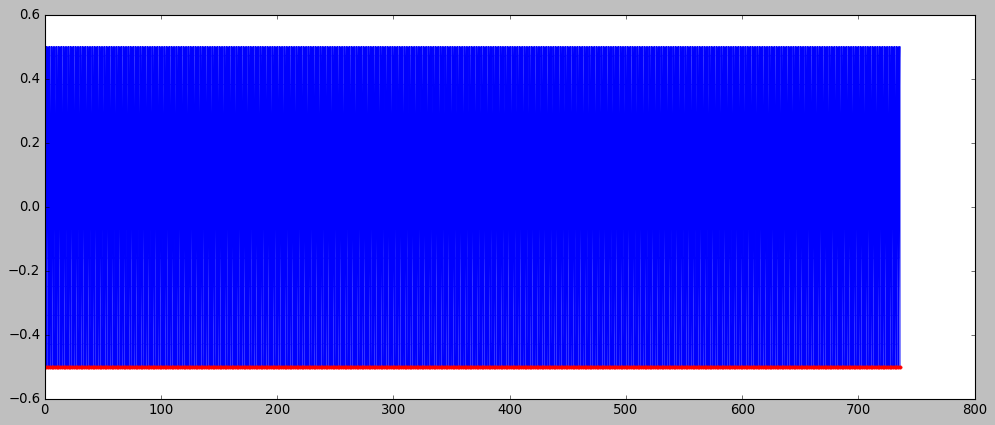

In [596]:
figsize(15,6)

dt = t[1] #This is the change in time
#Calculate the gradient of the cut data
#  Data was cut so that the beginning is the start of a sweep
#  and the end is the end of a sweep
grad = np.gradient(bias_cut,dt)
#identify the top 2000 gradient values
#  these are tied to the breakpoints for reseting the 
#  voltage sweep. There are 500 sweeps but multiple 
#  points capture the transition from 0.5 V to -0.5 V
swp_pnt = np.flip(np.argsort(absolute(grad)))[:2000]
count = 0
#iterate through all the detected sweep transition points
for j in swp_pnt:
    #Count the number of points above the set threshold
    #  This makes sure that only the points associated with
    #  sweep transition are saved
    if absolute(grad[j]) > 1000:
        count = count+1
print(count)
#Resort the gradient values and take the top count
swp_pnt = np.flip(np.argsort(absolute(grad)))[:count]
print(count)
#Order the sorted points, there are typically 2-3 neighboring 
#  points around the breakpoint that need to be filtered out
swp_pnt = np.flip(np.sort(swp_pnt))
#Iterate through all sorted points, removing close neighbors
print(len(swp_pnt))
for idx,point in enumerate(swp_pnt):
    temp_pnt = point
    #Where a value in the array is close to the point
    # set those values to 0
    swp_pnt[np.where(absolute(swp_pnt-point)<10)] = 0
    #This includes the point itself so redefine the point 
    # with its original value
    swp_pnt[idx] = point
#Remove any zeros that were set in the for loop
swp_pnt = np.sort(swp_pnt[swp_pnt != 0])
print(len(swp_pnt))
plot(t,bias_cut)
plot(t[swp_pnt],bias_cut[swp_pnt],'r.')
# plot(t,bias_cut)
# plot(t,grad)
start = 1.18
# xlim(0,5)
# xlim(700,750)
# ylim(-5,100)

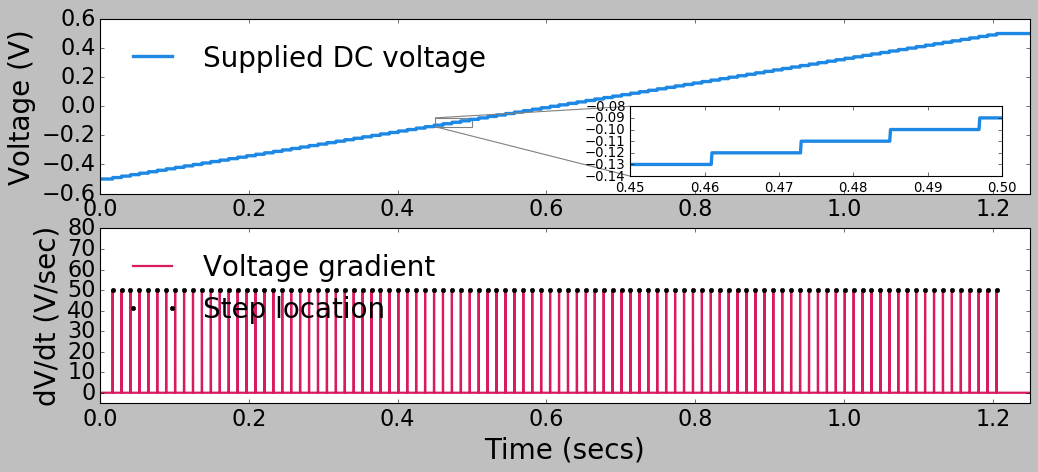

In [597]:

prev = 0
#iterate through each voltage sweep and determine the 
#  location of each step in the sweep
for brk in swp_pnt:
    #Section the grad calculation to the current sweep
    #  *'-1000' ensures the the break point between
    #   sweeps is not included
    grad_brk = grad[prev:brk-1000]
    #Determine the top 200 gradient values in this sweep
    #  *In this test data there were only about 100 voltage
    #    steps. With each step being captured by ~2 points. 
    #  **Based on the step magnitude and number this is subject 
    #    to change
    step_pnt = np.flip(np.argsort(absolute(grad_brk)))[:300]
    count = 0
    #Iterate through all 200 gradient values
    for j in step_pnt:
        #Determine if they meet the expected threshold
        if absolute(grad_brk[j]) > 20:
            count = count+1
    #Redefine the top count gradient values
    step_pnt = np.flip(np.argsort(absolute(grad_brk)))[:count]
    print(brk, end='\r')
    break
#Iterate through the determined points and remove any neighboring points
for idx,point in enumerate(step_pnt):
    temp_pnt = point
    #Set the value of any location within 10 pins of point to 0
    step_pnt[np.where(absolute(step_pnt-point)<10)] = 0
    #This also sets the point to 0, so reestablish its value
    step_pnt[idx] = point
#Remove any 0 values in the array
step_pnt = np.sort(step_pnt[step_pnt != 0])
#Ensure the last point in the array is indexed
step_pnt = np.append(step_pnt,len(grad_brk)-1)


from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
fig,ax = subplots(2,1)
figsize(15,10)

ax[0].plot(t[:brk-1000],bias_cut[:brk-1000],'#1e88e5',
           linewidth =3,label='Supplied DC voltage')
ax[0].grid(False)
ax[0].tick_params(labelsize=20)
ax[0].set_ylabel('Voltage (V)',size=25)
ax[0].legend(loc=2, fontsize = 25,fancybox=True, framealpha=0)
ax[0].set_xlim(0,1.25)
ax[0].set_ylim(-0.6,0.6)

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax[0], [0.57,0.1,0.4,0.4])
ax2.set_axes_locator(ip)
mark_inset(ax[0], ax2, loc1=2, loc2=3, fc="none", ec='0.5')

ax2.plot(t[:brk-delay],bias_cut[:brk-delay],'#1e88e5',label='Raw',linewidth=3)

ax2.grid(False)
ax2.tick_params(labelsize=12)
ax2.set_xlim(0.45,0.5)
ax2.set_ylim(-0.14,-0.08)

ax[1].plot(t[:brk-1000],abs(grad_brk),'#d81b60',
           linewidth=2,label='Voltage gradient')
ax[1].plot(t[step_pnt],abs(grad_brk[step_pnt]),'k.',
          markersize=8,label = 'Step location')
ax[1].tick_params(labelsize=20)
ax[1].set_xlabel('Time (secs)',size=25)
ax[1].set_ylabel('dV/dt (V/sec)',size=25)
ax[1].legend(loc=2, fontsize = 25,fancybox=True, framealpha=0)
ax[1].set_xlim(0,1.25)
ax[1].set_ylim(-5,80)
savefig('2020-03-13 Volt sweep loc',transparent=True)


In [235]:
#Find the avg of all 500 sweeps
print((0-swp_pnt[0]))
print(swp_pnt[0]-(swp_pnt[1]-3))
prev,count = 0,0
avg_swp = np.zeros((swp_pnt[1]-swp_pnt[0]),dtype='float64')
for brk in swp_pnt:
    avg_swp += cur_cut[prev:brk]
    count += 1
    prev=brk

avg_swp = avg_swp/count

-14743
-14740


14743


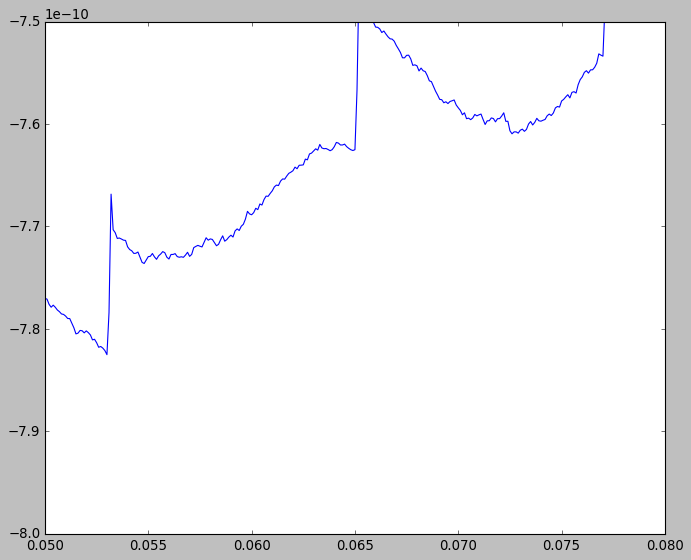

In [236]:
plot(t[:swp_pnt[0]],avg_swp)
# plot(t[:swp_pnt[0]],cur_cut[swp_pnt[0]:swp_pnt[1]])
# plot(t[:swp_pnt[0]],cur_cut[swp_pnt[1]:swp_pnt[2]])
xlim(0.05,0.08)
ylim(-0.8e-9,-0.75e-9)
print(len(avg_swp))

In [237]:
prev = 0 

I_n = np.zeros(len(step_pnt))
reps = np.zeros(len(step_pnt))
for idx,point in enumerate(step_pnt):
    I_n[idx] = mean(cur_cut[prev:point])
    reps[idx] = point-prev
    prev = point
reps[-1] = reps[-1] +1
# print(len(I_n),reps.astype('int'))
# print(I_n)
I_n = repeat(I_n,reps.astype('int'))
brk = swp_pnt[0]
print(len(cur_cut[:brk]),len(I_n),I_n[0])

14743 13743 -7.245883820710058e-10


In [238]:
#Calculate the Fourier transform of the measured geophone data
#   *In this case the test data is the last 80 seconds of the 
#    driven data set
g_test = geo_cut
G_m = fft.fft(g_test)
omega = fft.fftfreq(len(g_test),1/10000) #find the corresponding frequencies
#Interpolate the geophone frequency signal 
#  The harmonic calculation does not usually fall onto specific frequency bins,
#  the interpolation estimates the coefficient value if it falls between points
G_m = scipy.interpolate.interp1d(omega,G_m,kind='linear',fill_value='extrapolate')

z_noise = np.zeros(len(omega),dtype='complex128') #initialize noise array

#Use the coefficients and interpolated geophone signal to estimate z_noise
for i in arange(len(C[:])):
    n = i+1
    #Sum the impact that each harmonic has on the signal (Equation 2.4)
    z_noise += C[i](omega/n)*G_m(omega/n)



z_sp_n_vec  = tf.create_drive(geo_cut-mean(geo_cut))

In [364]:
# kappa = -24929385877.175434
kappa = -34715365715.10908
cur_mat_n = exp(-kappa*(fft.ifft(z_noise)-mean(fft.ifft(z_noise))))
cur_vec_n = exp(-kappa*(z_sp_n_vec-mean(z_sp_n_vec)))

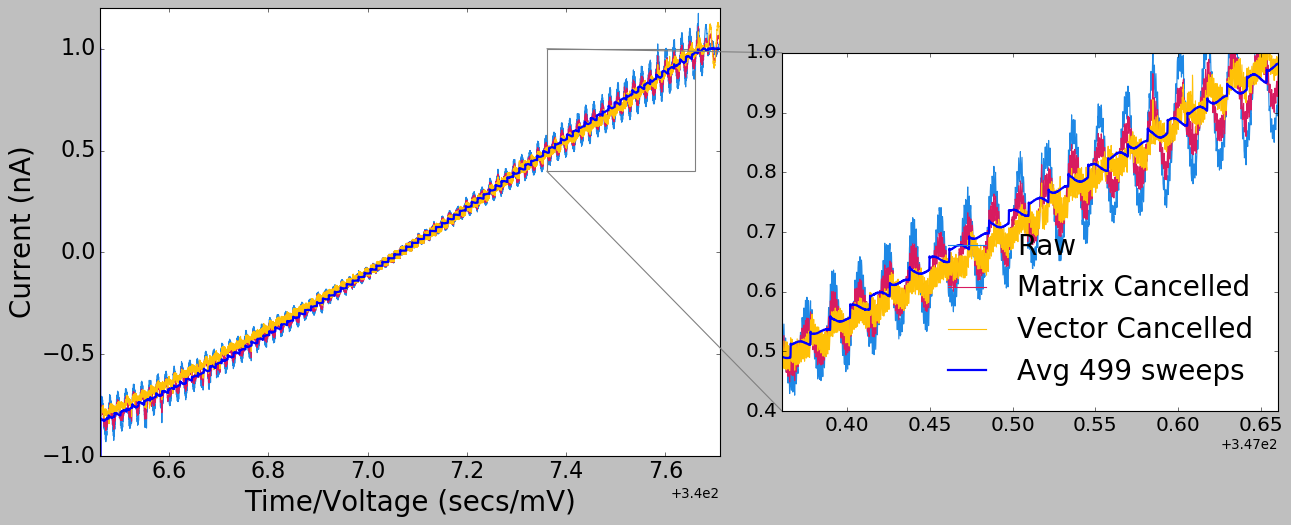

In [547]:
from mpl_toolkits.axes_grid.inset_locator import (
    inset_axes, InsetPosition,mark_inset)

prev,count = 0,0
avg_swp = np.zeros((swp_pnt[1]-swp_pnt[0]),dtype='float64')
#Sum through each voltage sweep and sum them together
for brk in swp_pnt:
    avg_swp += cur_cut[prev:brk]
    count += 1
    prev=brk
#Divide by the number of sweeps to get the average 
avg_swp = avg_swp/count

sweep = 235 #detail the sweep number to display
delay=10 #a delay is necessary to componsate for time 
         #  effects between the geophone/Z and current data
fig,ax1 = subplots()
figsize(10,10)
#Use sweep to determine which sweep to display
loc1 = swp_pnt[sweep-1] 
loc2 = swp_pnt[sweep]
ax1.plot(t[:brk-delay],1e9*cur_cut[:brk-delay],
         '#1e88e5',label='Raw')
ax1.plot(t[loc1:loc2-delay],1e9*(
    cur_cut[loc1:loc2-delay]/cur_mat_n[loc1+delay:loc2]),
         '#d81b60',label='Matrix Cancelled')
ax1.plot(t[loc1:loc2-delay],1e9*(
    cur_cut[loc1:loc2-delay]/cur_vec_n[loc1+delay:loc2]),
         '#ffc107',label='Vector Cancelled')
ax1.plot(t[loc1:loc2-delay],1e9*avg_swp[:-delay],
         'b',label='Averaged 500 sweeps',linewidth=2)
ax1.grid(False)
ax1.tick_params(labelsize=20)
ax1.set_xlabel('Time/Voltage (secs/mV)',size=25)
ax1.set_ylabel('Current (nA)',size=25)

ax1.set_xlim(t[loc1],t[loc1]+1.25)
ax1.set_ylim(-1,1.2)
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [1.1,0.1,0.8,0.8])
ax2.set_axes_locator(ip)
mark_inset(ax1, ax2, loc1=2, loc2=3, fc="none", ec='0.5')

ax2.plot(t[loc1:loc2-delay],1e9*cur_cut[loc1:loc2-delay],
         '#1e88e5',label='Raw')
ax2.plot(t[loc1:loc2-delay],1e9*(
    cur_cut[loc1:loc2-delay]/cur_mat_n[loc1+delay:loc2]),
         '#d81b60',label='Matrix Cancelled')
ax2.plot(t[loc1:loc2-delay],1e9*(
    cur_cut[loc1:loc2-delay]/cur_vec_n[loc1+delay:loc2]),
         '#ffc107',label='Vector Cancelled')
ax2.plot(t[loc1:loc2-delay],1e9*avg_swp[:-delay],
         'b',label='Avg 499 sweeps',linewidth=2)
ax2.grid(False)
ax2.tick_params(labelsize=18)
ax2.set_xlim(t[loc1]+0.9,t[loc1]+1.2)
ax2.set_ylim(0.4,1)
ax2.legend(loc=4, fontsize = 25,fancybox=True, framealpha=0)

savefig('2020-05-10 voltage sweep matrix-vec cancellation',transparent=True)

(-9e-10, -6e-10)

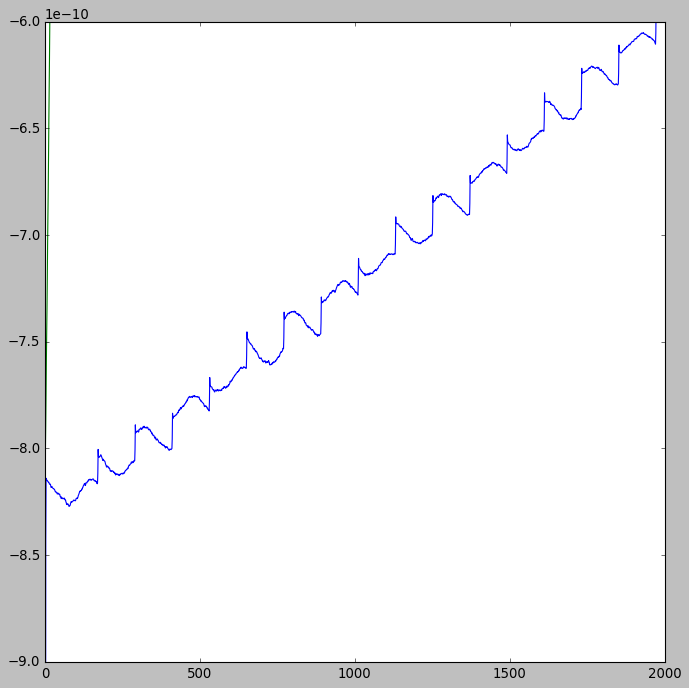

In [366]:
avg_IV = (mean(avg_swp[:14640].reshape(-1,120),axis=1))
plot(avg_swp)
plot(avg_IV[:])
xlim(0,2000)
ylim(-0.9e-9,-0.6e-9)

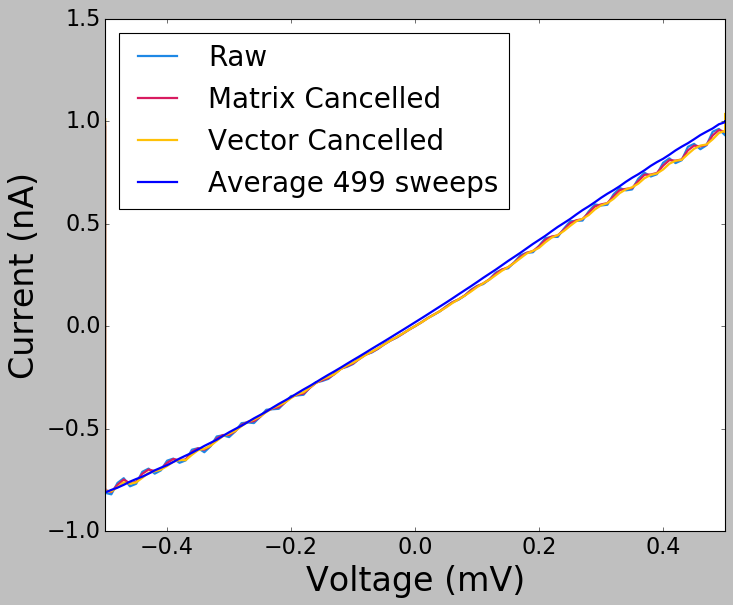

In [483]:
figsize(10,8)
sweep = 219 #detail the sweep number to display
delay=10 #a delay is necessary to componsate for time 
         #  effects between the geophone/Z and current data
#Use sweep to determine which sweep to display
loc1 = swp_pnt[sweep-1] 
loc2 = swp_pnt[sweep]

#Calculate the average value of current over each voltage step
#  to determine how current changes with each change of voltage
cur_IV = np.mean(cur_cut[:7356720].reshape(-1, 120), axis=1)
mat_IV = np.mean((cur_cut[:7356720]/
                  cur_mat_n[:7356720]).reshape(-1, 120), axis=1)
vec_IV = np.mean((cur_cut[:7356720]/
                  cur_vec_n[:7356720]).reshape(-1, 120), axis=1)

plot(bias_cut[loc1:loc2-delay:120],
     1e9*cur_IV[int(loc1/120):int((loc2-delay)/120)],
     '#1e88e5',label='Raw',linewidth=2)
plot(bias_cut[loc1:loc2-delay:120],
     1e9*mat_IV[int(loc1/120):int((loc2-delay)/120)],
     '#d81b60',label='Matrix Cancelled',linewidth=2)
plot(bias_cut[loc1:loc2-delay:120],
     1e9*(vec_IV[int(loc1/120):int((loc2-delay)/120)]),
     '#ffc107',label='Vector Cancelled',linewidth=2)
plot(bias_cut[loc1:loc2-120:120],1e9*avg_IV, 
     label='Average 499 sweeps',linewidth=2)
legend(loc=0,fontsize=25)
xlabel('Voltage (mV)',size=30)
ylabel('Current (nA)', size=30)
tick_params(labelsize=20)
xlim(-0.5,0.5)
savefig('2020-03-13 IV curve',transparent=True)
# ylim(-0.8,1)

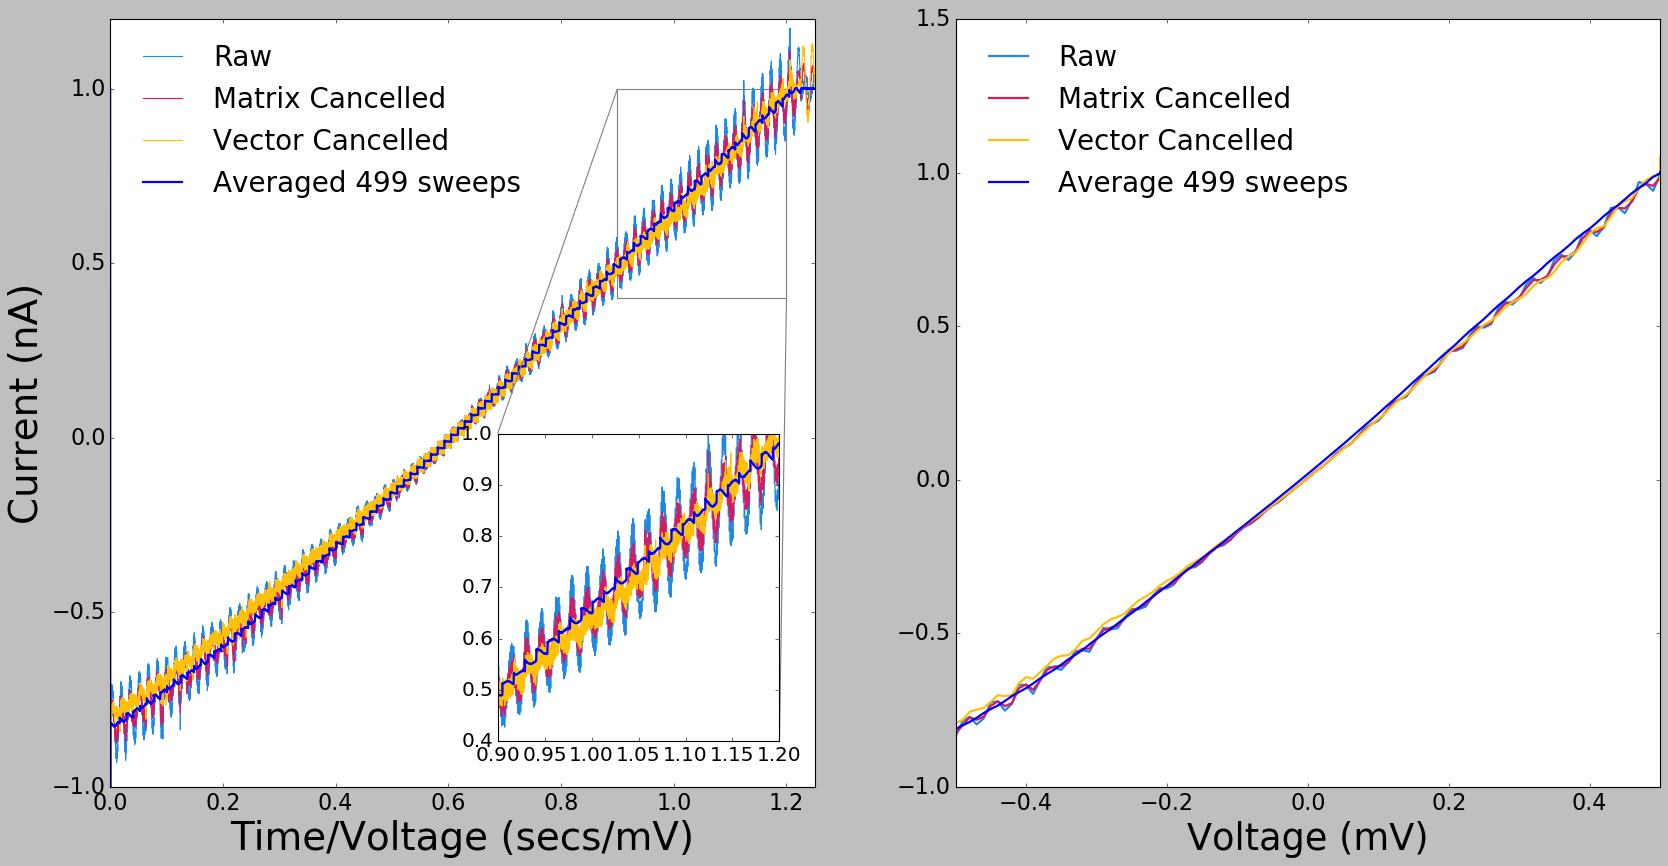

In [575]:
from mpl_toolkits.axes_grid.inset_locator import (
    inset_axes, InsetPosition,mark_inset)

prev,count = 0,0
avg_swp = np.zeros((swp_pnt[1]-swp_pnt[0]),dtype='float64')
#Sum through each voltage sweep and sum them together
for brk in swp_pnt:
    avg_swp += cur_cut[prev:brk]
    count += 1
    prev=brk
#Divide by the number of sweeps to get the average 
avg_swp = avg_swp/count

sweep = 235 #detail the sweep number to display
delay=10 #a delay is necessary to componsate for time 
         #  effects between the geophone/Z and current data
fig,ax = subplots(1,2)
figsize(25,12)
#Use sweep to determine which sweep to display
loc1 = swp_pnt[sweep-1] 
loc2 = swp_pnt[sweep]

#Calculate the average value of current over each voltage step
#  to determine how current changes with each change of voltage
cur_IV = np.mean(cur_cut[:7356720].reshape(-1, 120), axis=1)
mat_IV = np.mean((cur_cut[:7356720]/
                  cur_mat_n[:7356720]).reshape(-1, 120), axis=1)
vec_IV = np.mean((cur_cut[:7356720]/
                  cur_vec_n[:7356720]).reshape(-1, 120), axis=1)

ax[1].plot(bias_cut[loc1:loc2-delay:120],
     1e9*cur_IV[int(loc1/120):int((loc2-delay)/120)],
     '#1e88e5',label='Raw',linewidth=2)
ax[1].plot(bias_cut[loc1:loc2-delay:120],
     1e9*mat_IV[int(loc1/120):int((loc2-delay)/120)],
     '#d81b60',label='Matrix Cancelled',linewidth=2)
ax[1].plot(bias_cut[loc1:loc2-delay:120],
     1e9*(vec_IV[int(loc1/120):int((loc2-delay)/120)]),
     '#ffc107',label='Vector Cancelled',linewidth=2)
ax[1].plot(bias_cut[loc1:loc2-120:120],1e9*avg_IV, 
     label='Average 499 sweeps',linewidth=2)
ax[1].legend(loc=2, fontsize = 25,fancybox=True, framealpha=0)
ax[1].set_xlabel('Voltage (mV)',size=33)
ax[1].tick_params(labelsize=20)
ax[1].set_xlim(-0.5,0.5)

ax[0].plot(t[loc1:loc2-delay]-t[loc1],1e9*cur_cut[loc1:loc2-delay],
         '#1e88e5',label='Raw')
ax[0].plot(t[loc1:loc2-delay]-t[loc1],1e9*(
    cur_cut[loc1:loc2-delay]/cur_mat_n[loc1+delay:loc2]),
         '#d81b60',label='Matrix Cancelled')
ax[0].plot(t[loc1:loc2-delay]-t[loc1],1e9*(
    cur_cut[loc1:loc2-delay]/cur_vec_n[loc1+delay:loc2]),
         '#ffc107',label='Vector Cancelled')
ax[0].plot(t[loc1:loc2-delay]-t[loc1],1e9*avg_swp[:-delay],
         'b',label='Averaged 499 sweeps',linewidth=2)
ax[0].grid(False)
ax[0].tick_params(labelsize=20)
ax[0].set_xlabel('Time/Voltage (secs/mV)',size=35)
ax[0].set_ylabel('Current (nA)',size=35)

ax[0].set_xlim(0,1.25)
ax[0].set_ylim(-1,1.2)
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax[0], [0.55,0.06,0.4,0.4])
ax2.set_axes_locator(ip)
mark_inset(ax[0], ax2, loc1=2, loc2=4, fc="none", ec='0.5')

ax2.plot(t[loc1:loc2-delay]-t[loc1],1e9*cur_cut[loc1:loc2-delay],
         '#1e88e5',label='Raw')
ax2.plot(t[loc1:loc2-delay]-t[loc1],1e9*(
    cur_cut[loc1:loc2-delay]/cur_mat_n[loc1+delay:loc2]),
         '#d81b60',label='Matrix Cancelled')
ax2.plot(t[loc1:loc2-delay]-t[loc1],1e9*(
    cur_cut[loc1:loc2-delay]/cur_vec_n[loc1+delay:loc2]),
         '#ffc107',label='Vector Cancelled')
ax2.plot(t[loc1:loc2-delay]-t[loc1],1e9*avg_swp[:-delay],
         'b',label='Avg 499 sweeps',linewidth=2)
ax2.grid(False)
ax2.tick_params(labelsize=18)
ax2.set_xlim(0.9,1.2)
ax2.set_ylim(0.4,1)
ax[0].legend(loc=2, fontsize = 25,fancybox=True, framealpha=0)
savefig('2020-03-13 IV and IVT curves',transparent=True)

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:68: ComplexWarning: Casting complex values to real discards the imaginary part


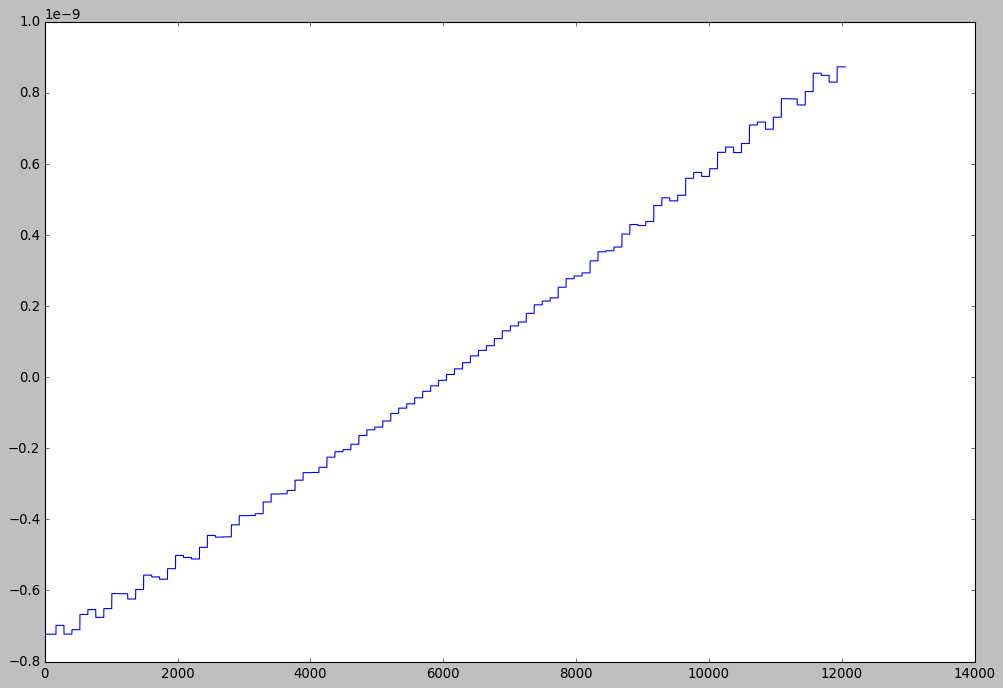

In [666]:
def rms(array,n=1):
    return sqrt(mean((fit_cancel(array,n))**2))

dt = t[1] #The change in time during data collection
grad = np.gradient(bias_cut,dt)
delay = 10
cur_mat = cur_cut[:-delay]/cur_mat_n[delay:]
cur_vec = cur_cut[:-delay]/cur_vec_n[delay:]
#Iterate through each sweep
prev = 0
start = time.time()
rms_cur = np.zeros((len(swp_pnt)))
rms_cur_mat = np.zeros((len(swp_pnt)))
rms_cur_vec = np.zeros((len(swp_pnt)))
for idx_brk,brk in enumerate(swp_pnt):
    #find the step points in the 
    grad_brk = grad[prev:brk-1000]
    #Determine the top 200 gradient values in this sweep
    #  *In this test data there were only about 100 voltage
    #    steps. With each step being captured by ~2 points. 
    #  **Based on the step magnitude and number this is subject 
    #    to change
    step_pnt = np.flip(np.argsort(absolute(grad_brk)))[:300]

    count = 0
    #Iterate through all 200 gradient values
    for j in step_pnt:
        #Determine if they meet the expected threshold
        if absolute(grad_brk[j]) > 20:
            count = count+1
    #Redefine the top count gradient values
    step_pnt = np.flip(np.argsort(absolute(grad_brk)))[:count]
    #Iterate through the determined points and remove any neighboring points
    for idx,point in enumerate(step_pnt):
        temp_pnt = point
        #Set the value of any location within 10 pins of point to 0
        step_pnt[np.where(absolute(step_pnt-point)<10)] = 0
        #This also sets the point to 0, so reestablish its value
        step_pnt[idx] = point
    #Remove any 0 values in the array
    step_pnt = np.sort(step_pnt[step_pnt != 0])
    step_pnt = prev + step_pnt
    #Ensure the last point in the array is indexed
#     step_pnt = np.append(step_pnt,len(grad_brk)-1)
#     pv = 0
    
#     for idx,point in enumerate(step_pnt):
#         rms_cur[idx_brk,idx] = rms(cur_cut[pv:point])
#         rms_cur_mat[idx_brk,idx] = rms(cur_mat[pv:point])
#         rms_cur_vec[idx_brk,idx] = rms(cur_vec[pv:point])
    
    I_n,reps = np.zeros(len(step_pnt)),np.zeros(len(step_pnt))
    #Calculate the average current value at each voltage step
    pv=prev
    for idx,point in enumerate(step_pnt):
#         print(pv,point)
        I_n[idx] = mean(cur_cut[pv:point])
        reps[idx] = point-pv
        pv = point
    reps[-1] = reps[-1] +1

    #Repeat the calculated numbers to ensure that it 
    #  is the same shape as the sweep
    I_n = repeat(I_n,reps.astype('int'))
    
    rms_cur[idx_brk] = rms(cur_cut[prev:point]-I_n[:-1]) 
    rms_cur_mat[idx_brk] = rms(cur_mat[prev:point]-I_n[:-1])
    rms_cur_vec[idx_brk] = rms(cur_vec[prev:point]-I_n[:-1])
    print(idx_brk,end='\r')
    prev = brk
#     break

# plot(rms_cur[:,0])
# xlim()
# plot(cur_cut[0:point])
# print(len(cur_cut[0:point]))
# plot(I_n)
# plot(cur_cut[0:point]-I_n[:-1],'r')

IV Mat mean: 32.584356407857044
IV Mat std: 1.2927723662627835
IV Vec mean: 41.18493844149013
IV Vec std: 1.1876597221563234


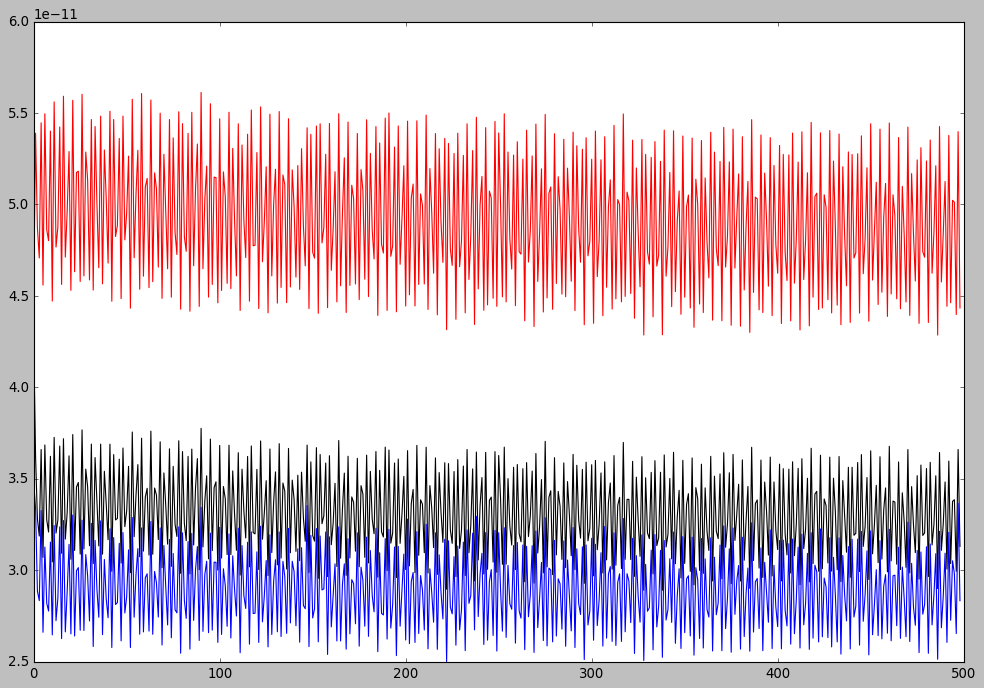

In [669]:
# plot(mean(rms_cur,axis=0),'k')
plot(rms_cur,'r')
plot(rms_cur_mat,'k')
plot(rms_cur_vec,'b')
mat_canc = 100-100*(rms_cur_mat/rms_cur)
vec_canc = 100 - 100*(rms_cur_vec/rms_cur)
print('IV Mat mean:', mean(mat_canc))
print('IV Mat std:', std(mat_canc))
print('IV Vec mean:', mean(vec_canc))
print('IV Vec std:', std(vec_canc))
# plot(rms_cur_vec[5,:],'b')
# plot(cur_cut[0:point])
# plot(cur_cut[0:point]-I_n[:-1])

0.00282598111230814
0.028584078906809696


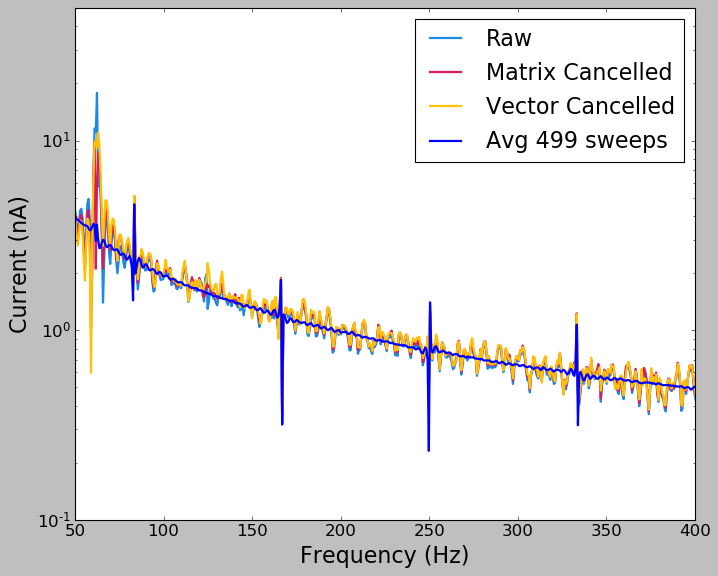

In [671]:
fig,ax1 = subplots()
figsize(10,8)
#Calculate the Fourier transform of each set of data
fft_cur_swp = 1e12*fft.fft(cur_cut[loc1:loc2-delay])/len(cur_cut[loc1:loc2-delay])
fft_cur_mat = 1e12*fft.fft((cur_cut[loc1:loc2-delay]/cur_mat_n[loc1+delay:loc2]))/len(cur_cut[loc1:loc2-delay])
fft_cur_vec = 1e12*fft.fft((cur_cut[loc1:loc2-delay]/cur_vec_n[loc1+delay:loc2]))/len(cur_cut[loc1:loc2-delay])
fft_cur_avg = 1e12*fft.fft(avg_swp)/len(avg_swp)

frq_swp = fft.fftfreq(len(fft_cur_swp),1/10000)

ax1.semilogy(frq_swp[:int(len(frq_swp)/2)],absolute(fft_cur_swp[:int(len(frq_swp)/2)]),'#1e88e5',label='Raw',linewidth=2)
ax1.semilogy(frq_swp[:int(len(frq_swp)/2)],absolute(fft_cur_mat[:int(len(frq_swp)/2)]),'#d81b60',label='Matrix Cancelled',linewidth=2)
ax1.semilogy(frq_swp[:int(len(frq_swp)/2)],absolute(fft_cur_vec[:int(len(frq_swp)/2)]),'#ffc107',label='Vector Cancelled',linewidth=2)
ax1.semilogy(frq_swp[:int(len(frq_swp)/2)],absolute(fft_cur_avg[:int(len(frq_swp)/2)]),'b',label='Avg 499 sweeps',linewidth=2)
print(1-absolute(sqrt(mean(fft_cur_mat[:1000]**2))/sqrt(mean(fft_cur_swp[:1000]**2))))
print(1-absolute(sqrt(mean(fft_cur_vec[:1000]**2))/sqrt(mean(fft_cur_swp[:1000]**2))))
ax1.legend(loc=1,fontsize=20)
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Frequency (Hz)',size=20)
ax1.set_ylabel('Current (nA)',size=20)

ax1.set_xlim(50,400)
ax1.set_ylim(1e-1,5e1)
savefig('2020-03-13 Current sweep fft',transparent=True)

14743 29486


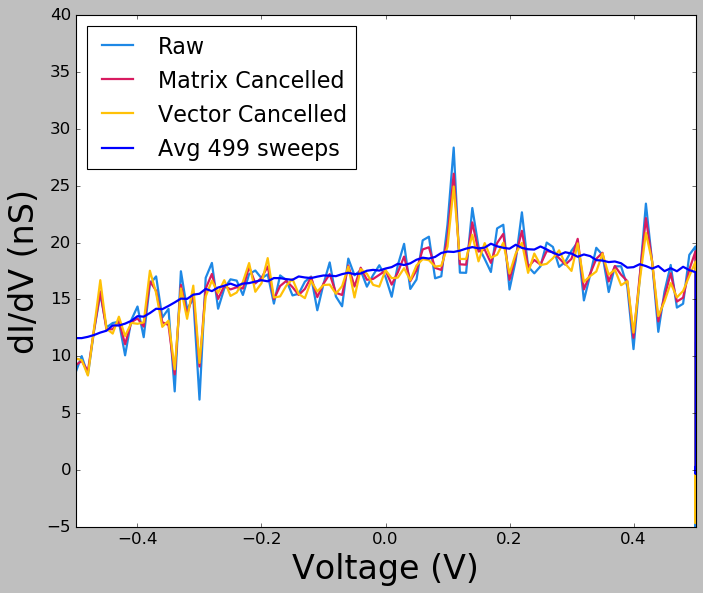

In [683]:
# kappa = -34715365715.10908 #experimentally found kappa value
# #noise calculation for the matrix and vector estimation
# cur_mat_n = exp(-kappa*(fft.ifft(z_noise)
#                         -mean(fft.ifft(z_noise))))
# cur_vec_n = exp(-kappa*(z_sp_n_vec-mean(z_sp_n_vec)))

#average each sweep together to find the 'Ground Truth'
prev,count = 0,0
avg_liy = np.zeros((swp_pnt[1]-swp_pnt[0]),dtype='float64')
#Sum through each voltage sweep and sum them together
for brk in swp_pnt:
    avg_liy += LIY_cut[prev:brk]
    count += 1
    prev=brk
#Divide by the number of sweeps to get the average 
avg_liy = avg_liy/count


sweep = 219 #detail the sweep number to display
#Use sweep to determine which sweep to display
loc1 = swp_pnt[sweep-1] 
loc2 = swp_pnt[sweep]
print(swp_pnt[0],swp_pnt[1])
#Implement Equation 2.14
liy_mat = (LIY_cut/cur_mat_n)
liy_vec = (LIY_cut/cur_vec_n)
#Implement Equation 2.14
mat_rep = repeat(np.mean(
    liy_mat[:7356740].reshape(-1, 10), axis=1),10)
vec_rep = repeat(np.mean(
    liy_vec[:7356740].reshape(-1, 10), axis=1),10)


plot(bias_cut[loc1:loc2-delay:120],
     1e12*LIY_cut[loc1:loc2-delay:120],
     '#1e88e5',label='Raw',linewidth=2)
plot(bias_cut[loc1:loc2-delay:120],
     1e12*mat_rep[loc1:loc2-delay:120],
     '#d81b60',label='Matrix Cancelled',linewidth=2)
plot(bias_cut[loc1:loc2-delay:120],
     1e12*vec_rep[loc1:loc2-delay:120],
     '#ffc107',label='Vector Cancelled',linewidth=2)
plot(bias_cut[loc1:loc2-delay:120],
     1e12*avg_liy[::120],
     'b',label='Avg 499 sweeps',linewidth=2)

legend(loc=0,fontsize=20)
xlabel('Voltage (V)',size=30)
ylabel('dI/dV (nS)',size=30)
tick_params(labelsize=15)

xlim(-0.5,0.5)
ylim(-5,40)
savefig('2020-03-13 dIdV curve canc',transparent=True)

(123,)
LIY std from avg:  3.0159851261646278 nS
Mat std from avg:  2.659433277201534 nS
Vec std from avg:  2.605150446279709 nS
Mat reduction:  12.205071460154164
Mat std:  9.34136414893085
Vec reduction:  41.22824679356295
Vec std:  0.8447267451227543


C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


(-5, 130)

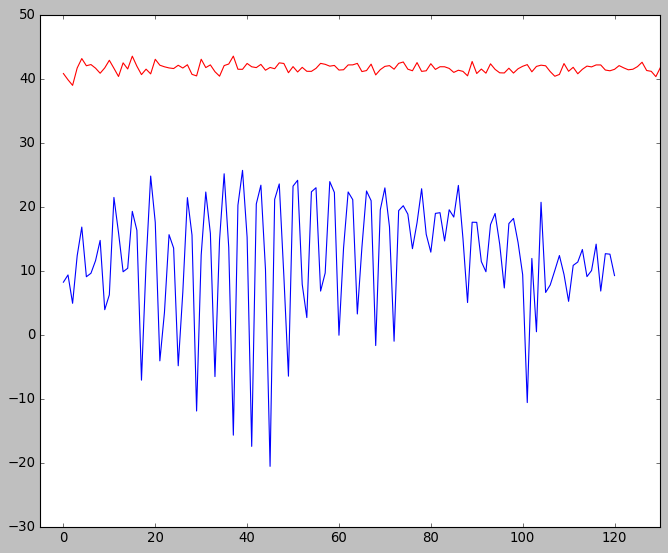

In [713]:
def rms(array,n=1):
    return sqrt(mean((fit_cancel(array,n))**2))

#Implement Equation 2.14
liy_mat = (LIY_cut/cur_mat_n)
liy_vec = (LIY_cut/cur_vec_n)
#Implement Equation 2.14
mat_rep = repeat(np.mean(
    liy_mat[:7356740].reshape(-1, 10), axis=1),10)
vec_rep = repeat(np.mean(
    liy_vec[:7356740].reshape(-1, 10), axis=1),10)
#Creates arrays of the shape for dI/dV vs V
liy_calc = np.zeros((len(swp_pnt),123))
liy_mat_calc = np.zeros((len(swp_pnt),123))
liy_vec_calc = np.zeros((len(swp_pnt),123))

prev = 0
for idx,sweep in enumerate(swp_pnt):
    loc1 = prev
    loc2 = sweep
    liy_calc[idx,:] = LIY_cut[loc1:loc2-delay:120] - avg_liy[::120]
    liy_mat_calc[idx,:] = mat_rep[loc1:loc2-delay:120] - avg_liy[::120]
    liy_vec_calc[idx,:] = vec_rep[loc1:loc2-delay:120] - avg_liy[::120]
    prev=sweep
print(shape(std(1e12*liy_calc,axis=0)))
liy_std = (std(1e12*liy_calc,axis=0))
mat_std = (std(1e12*liy_mat_calc,axis=0))
vec_std = (std(1e12*liy_vec_calc,axis=0))
mat_canc = 100-100*abs(mat_std/liy_std)
vec_cenc = 100-100*abs(vec_std/liy_std)
print('LIY std from avg: ',mean(liy_std),'nS')
print('Mat std from avg: ',mean(mat_std),'nS')
print('Vec std from avg: ',mean(vec_std),'nS')
print('Mat reduction: ', mean(mat_canc[2:]))
print('Mat std: ', std(mat_canc[2:]))
print('Vec reduction: ', mean(vec_canc[2:]))
print('Vec std: ', std(vec_canc[2:]))
# plot(liy_std,'k')
plot(mat_canc[2:],'b')
plot(vec_canc[2:],'r')
xlim(-5,130)

62.4845843952972
78.69733895443615
30.132663146515753


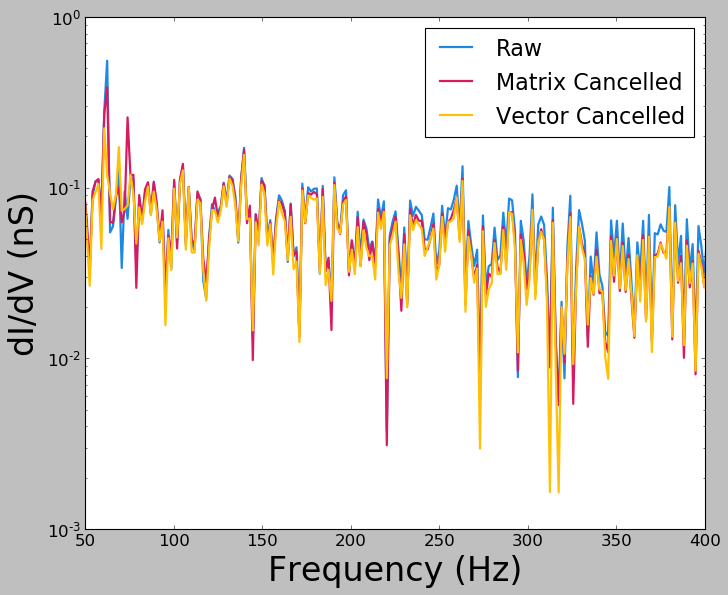

In [720]:
liy_fft = np.zeros(len(LIY_cut[loc1:loc2-2580]),dtype='complex128')
liy_mat_fft = np.zeros(len(LIY_cut[loc1:loc2-2580]),dtype='complex128')
liy_vec_fft = np.zeros(len(LIY_cut[loc1:loc2-2580]),dtype='complex128')
freqs = fft.fftfreq(len(liy_mat_fft),1/10000)
prev = 0
#average the fft taken over each sweep to reduce noise
for pnt in swp_pnt[:499]:
    x = (pnt-prev) -len(liy_fft)
    liy_fft = liy_fft + fft.fft(1e12*LIY_cut[prev:pnt-x])
    liy_mat_fft = liy_mat_fft + fft.fft(1e12*mat_rep[prev:pnt-x])
    liy_vec_fft = liy_vec_fft + fft.fft(1e12*vec_rep[prev:pnt-x])
liy_fft = (liy_fft/499)/len(liy_fft)
liy_mat_fft = (liy_mat_fft/499)/len(liy_mat_fft)
liy_vec_fft = (liy_vec_fft/499)/len(liy_vec_fft)
avg_liy_fft = fft.fft(1e12*avg_liy)/len(avg_liy)

semilogy(freqs[:int(len(freqs)/2):2],
         absolute(liy_fft[:int(len(freqs)/2):2]),
         '#1e88e5',label='Raw',linewidth=2)
semilogy(freqs[:int(len(freqs)/2):2],
         absolute(liy_mat_fft[:int(len(freqs)/2):2]),
         '#d81b60',label='Matrix Cancelled',linewidth=2)
semilogy(freqs[:int(len(freqs)/2):2],
         absolute(liy_vec_fft[:int(len(freqs)/2):2]),
         '#ffc107',label='Vector Cancelled',linewidth=2)
# semilogy(freqs[:int(len(freqs)/2):2],
#          absolute(avg_liy_fft[:int(len(freqs)/2):2]),
#          'b',label='Avg 499 Sweeps',linewidth=2)
xlim(50,400)
# ylim(1e-3,1e2)
ylim(1e-3,1e0)
legend(loc=0,fontsize=20)
tick_params(labelsize=15)
xlabel('Frequency (Hz)',size=30)
ylabel('dI/dV (nS)',size=30)
savefig('2020-4-10 dIdV freq map',transparent=True)